# CS4035 - Cyber Data Analytics
## Lab 2 

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 2 contains 7 main questions, including the bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 


## Group Number : 29

## Student 1 
### Name : Mingyu Gao
### ID : 5216281

## Student 2
### Name : Yuhang Tian
### ID : 5219728

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [1]:
import numpy as np
import pandas as pd 

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf


from tqdm import tqdm
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns

from jupyterthemes import jtplot
jtplot.style('grade3')

import warnings
warnings.filterwarnings('ignore')

## 1. Familiarization task – 1 A4

### 1a. Plot visualizations 

In [2]:
# load the data
training_data = pd.read_csv('./SWaT_train.csv')
testing_data = pd.read_csv('./SWaT_test.csv')
# delete timestamp and extract label in the training data set
training_signals = training_data.drop(columns=[' Timestamp', 'Normal/Attack'])
training_label = training_data['Normal/Attack']
training_label = np.where(training_label.to_numpy() == 'Normal', 0, 1)
# delete timestamp and extract label in the testing data set
testing_signals = testing_data.drop(columns=['Unnamed: 0', ' Timestamp', 'Normal/Attack'])
testing_label = testing_data['Normal/Attack']
testing_label = np.where(testing_label.to_numpy() == 'Normal', 0, 1)

training_data.head()

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,22/12/2015 4:00:00 PM,2.470294,261.5804,2,2,1,244.3284,8.19008,306.101,2.471278,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
1,22/12/2015 4:00:01 PM,2.457163,261.1879,2,2,1,244.3284,8.19008,306.101,2.468587,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
2,22/12/2015 4:00:02 PM,2.439548,260.9131,2,2,1,244.3284,8.19008,306.101,2.467305,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
3,22/12/2015 4:00:03 PM,2.428338,260.2850,2,2,1,244.3284,8.19008,306.101,2.466536,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
4,22/12/2015 4:00:04 PM,2.424815,259.8925,2,2,1,244.4245,8.19008,306.101,2.466536,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal



 Figure1: Visualize training data set


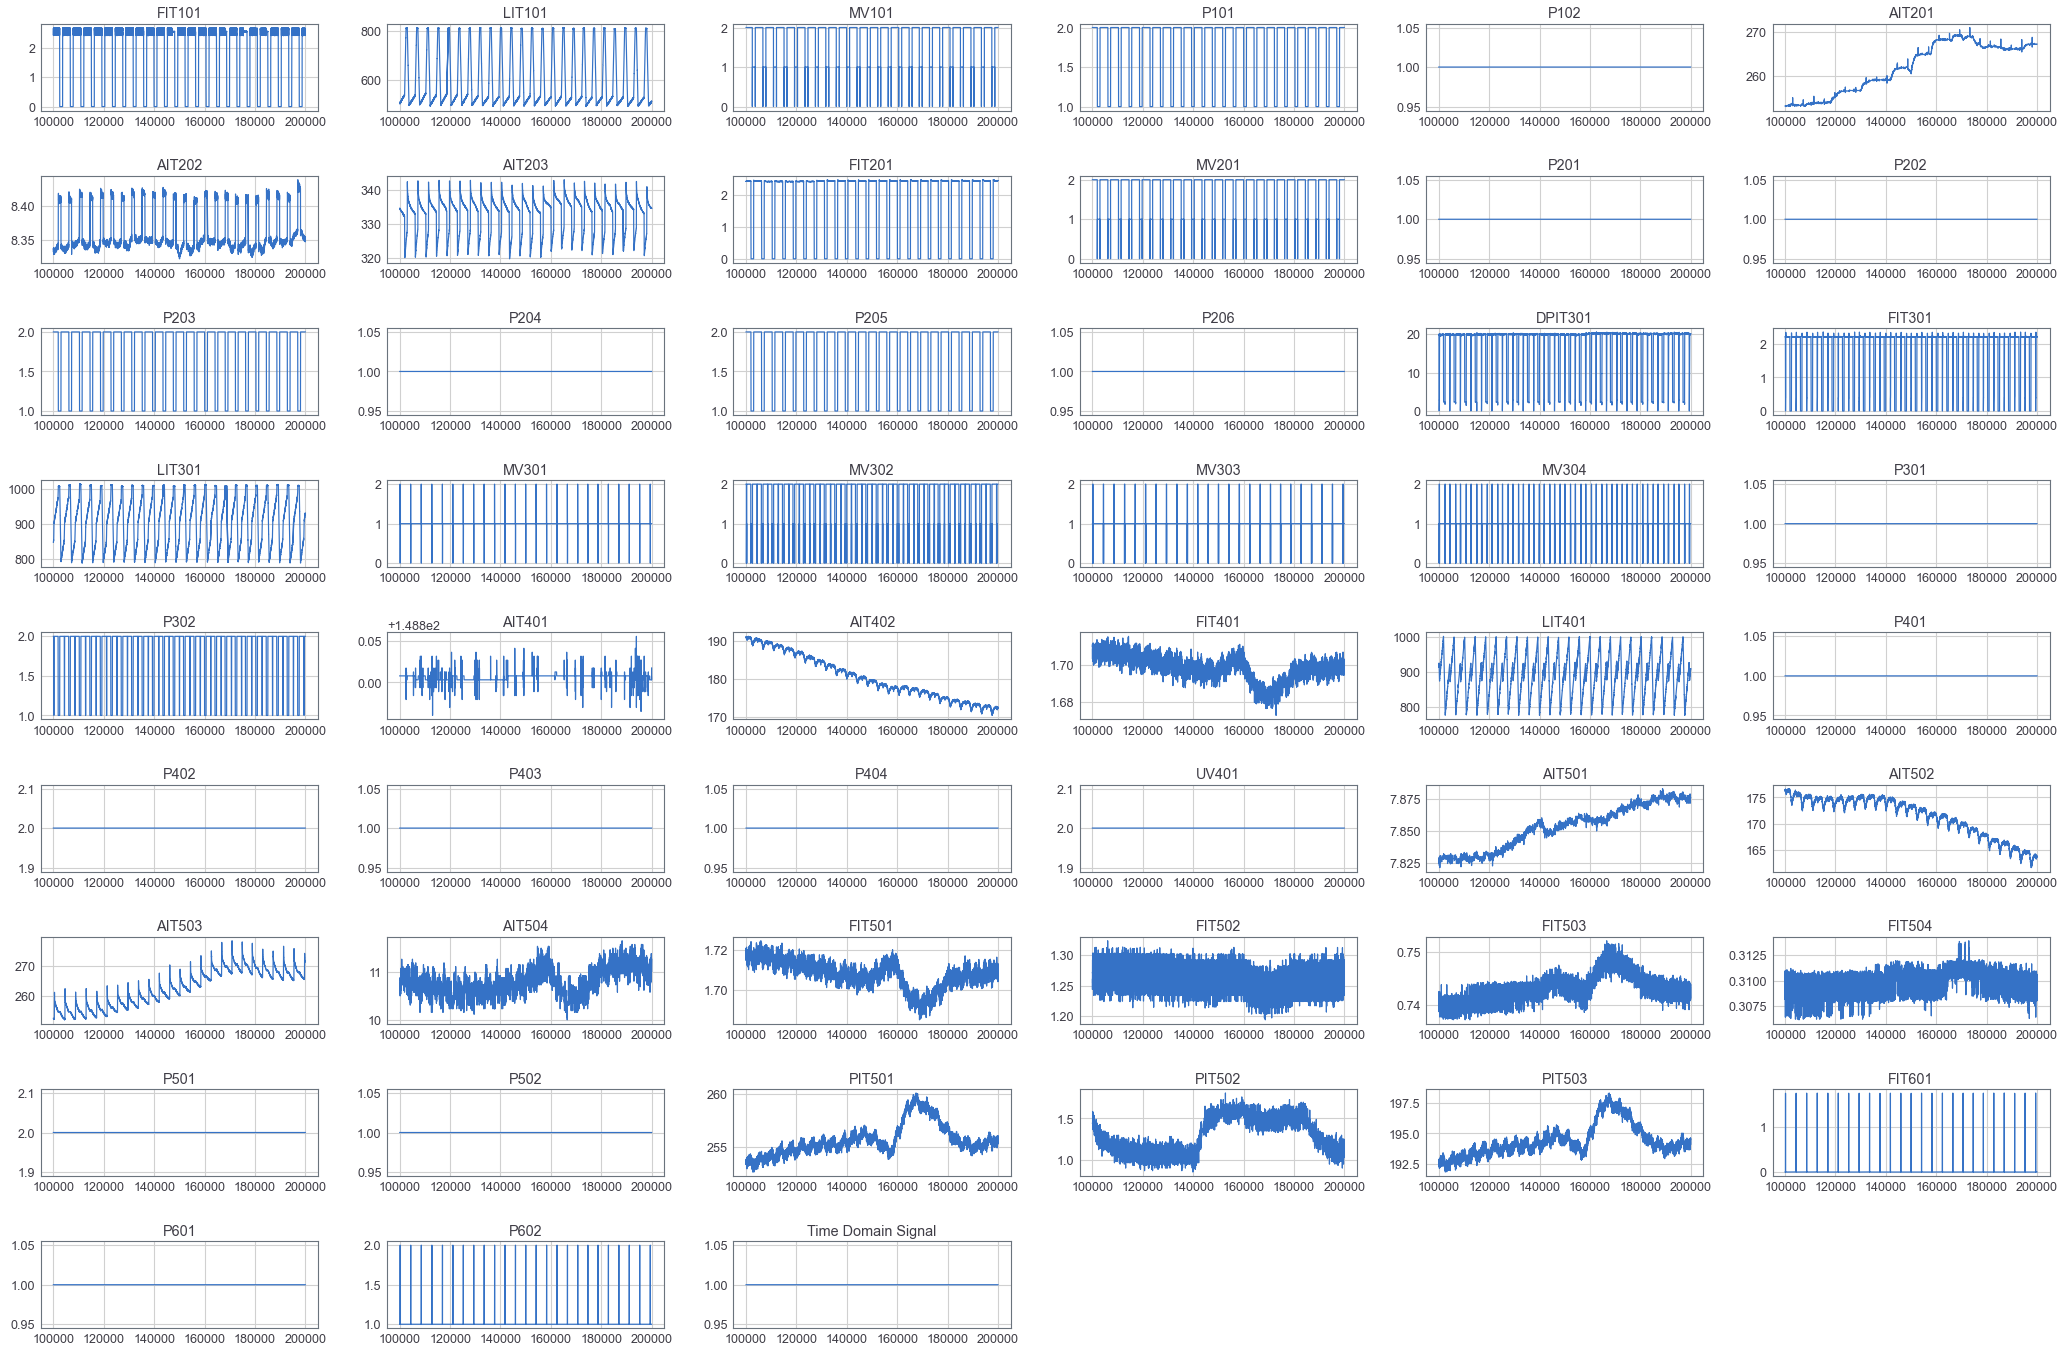

In [3]:
# to visualize part of training data set
i = 1
plt.figure(figsize=(36, 24))
plt.subplots_adjust(wspace=0.25, hspace=0.75)
for col in list(training_signals.columns):
    plt.subplot(9, 6, i)
    training_signals.loc[100000:200000, col].plot()
    plt.title(col)
    i += 1
print("\n Figure1: Visualize training data set")
plt.title("Time Domain Signal")
plt.show()


 Figure2: Visualize the correlation matrix of all signals


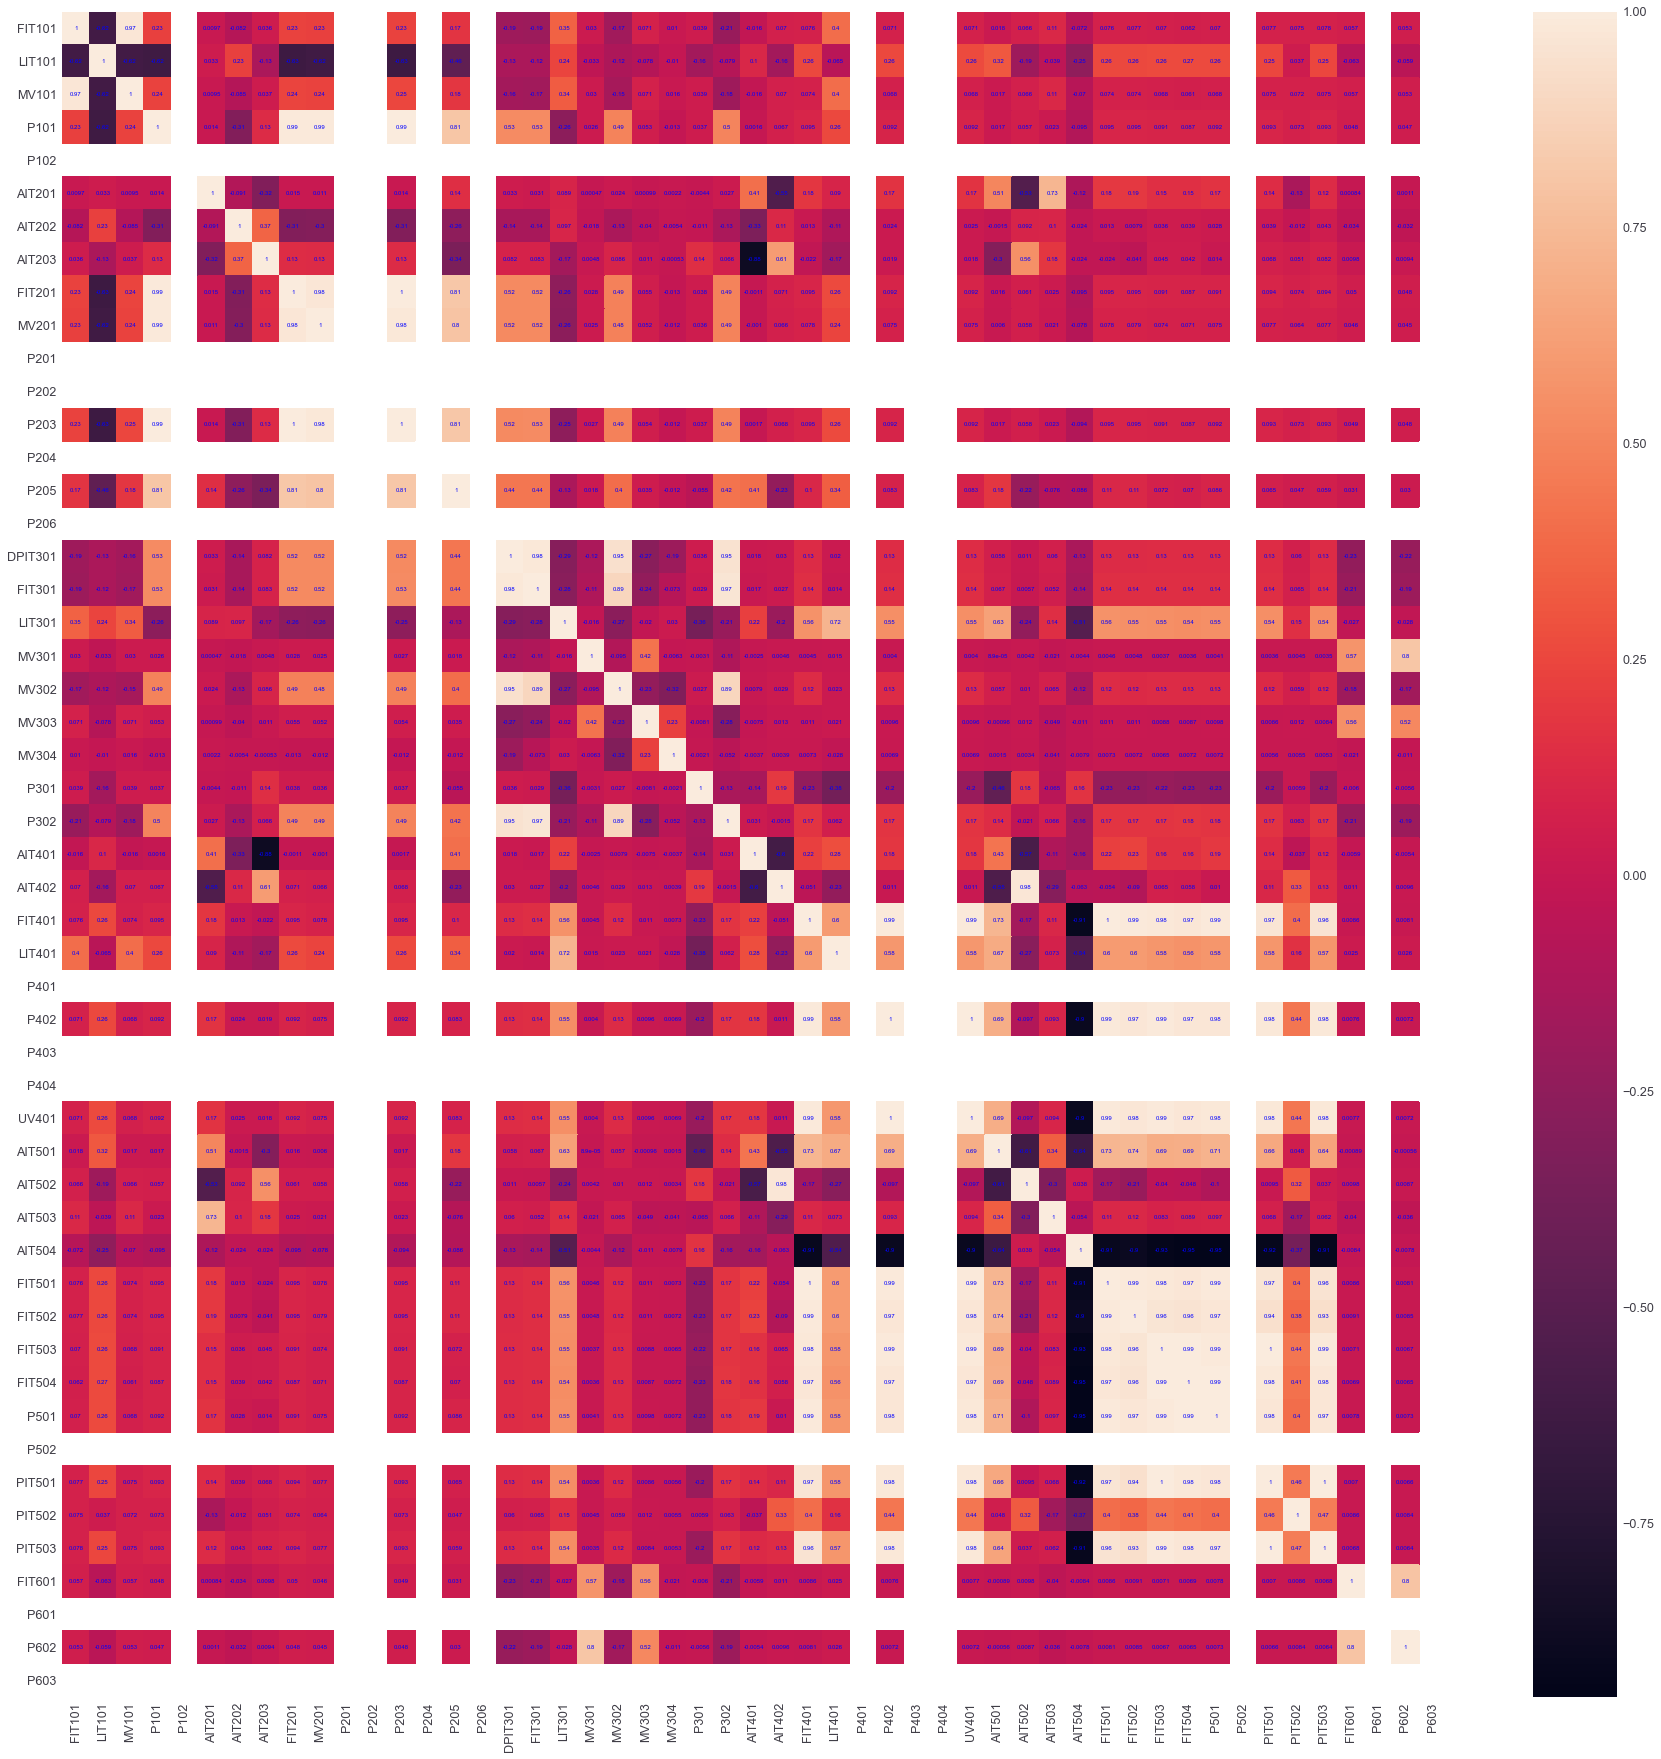

In [4]:
# to plot correlation matrix
corr = training_signals.corr()
plt.figure(figsize=(31,31))
sns.heatmap(corr, xticklabels=list(corr.columns), annot=True, yticklabels=list(corr.columns), annot_kws={'size':6,'color':'blue'})
print("\n Figure2: Visualize the correlation matrix of all signals")
plt.show()

In [5]:
# the function to draw part of one signal
def plot_signal(data,col,start=0,end=10000,title="",color="blue"):
	f,ax = plt.subplots(figsize=(22,3))
	f.suptitle(title)
	ax = sns.lineplot(data=data.loc[start:end,col],color=color)
	ax.set_xticks(range(start,end+1,5000))
	plt.show()	


Figure 3: perfectly correlated signals


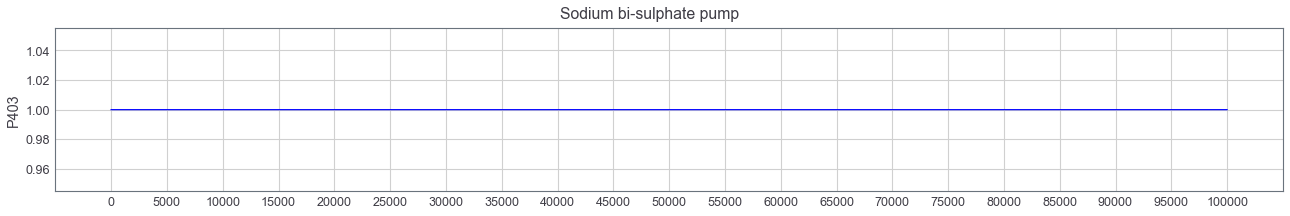

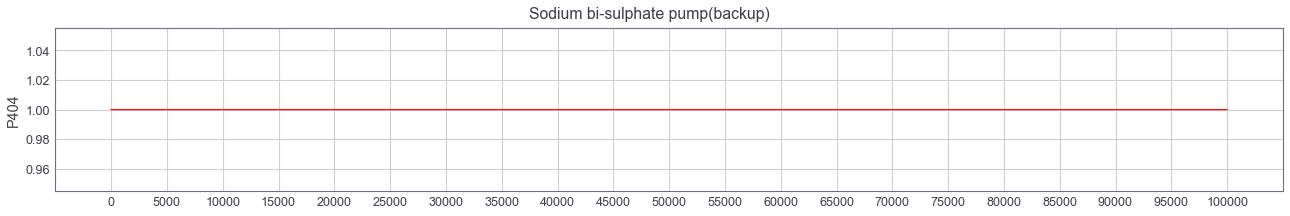


Figure 4: perfectly negatively correlated signals


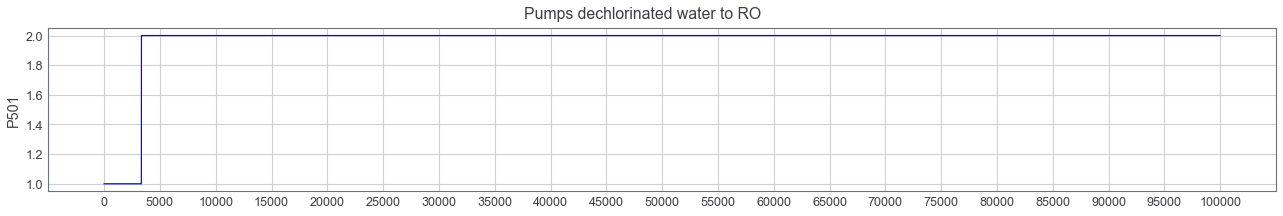

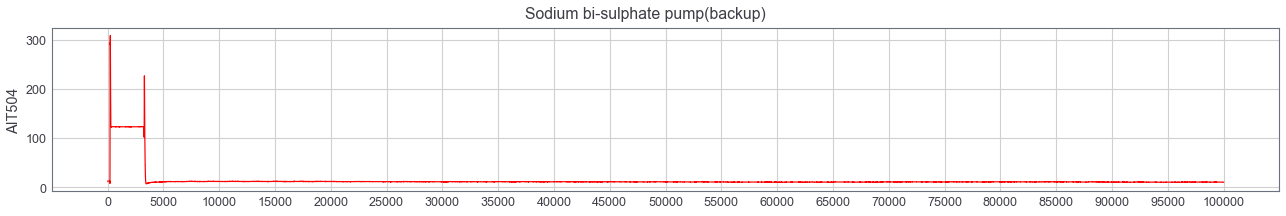

In [6]:
# Example of almost perfectly correlated signals
print("\nFigure 3: perfectly correlated signals")
plot_signal(training_signals,"P403",0,100000,"Sodium bi-sulphate pump","blue")
plot_signal(training_signals,"P404",0,100000,"Sodium bi-sulphate pump(backup)","red")

# Example of almost perfectly negatively correlated signals
print("\nFigure 4: perfectly negatively correlated signals")
plot_signal(training_signals,"P501",0,100000,"Pumps dechlorinated water to RO","blue")
plot_signal(training_signals,"AIT504",0,100000,"Sodium bi-sulphate pump(backup)","red")

In [7]:
# function of sliding_window for the forcast
def sliding_window(df, window_size, stride=1):
    '''
    df: the input data frame
    window_size: size of sliding window
    stride: the stepsize
    '''
    # N is the number of sliding windows
    N = np.floor((len(df) - window_size)/stride).astype(np.int)+1
    # result after being slided
    return_window = []
    for i in range(N):
        return_window.append(df[i*stride:i*stride+window_size])
    return np.array(return_window)


 Figure5: the prediction of four signals after applying sliding windows


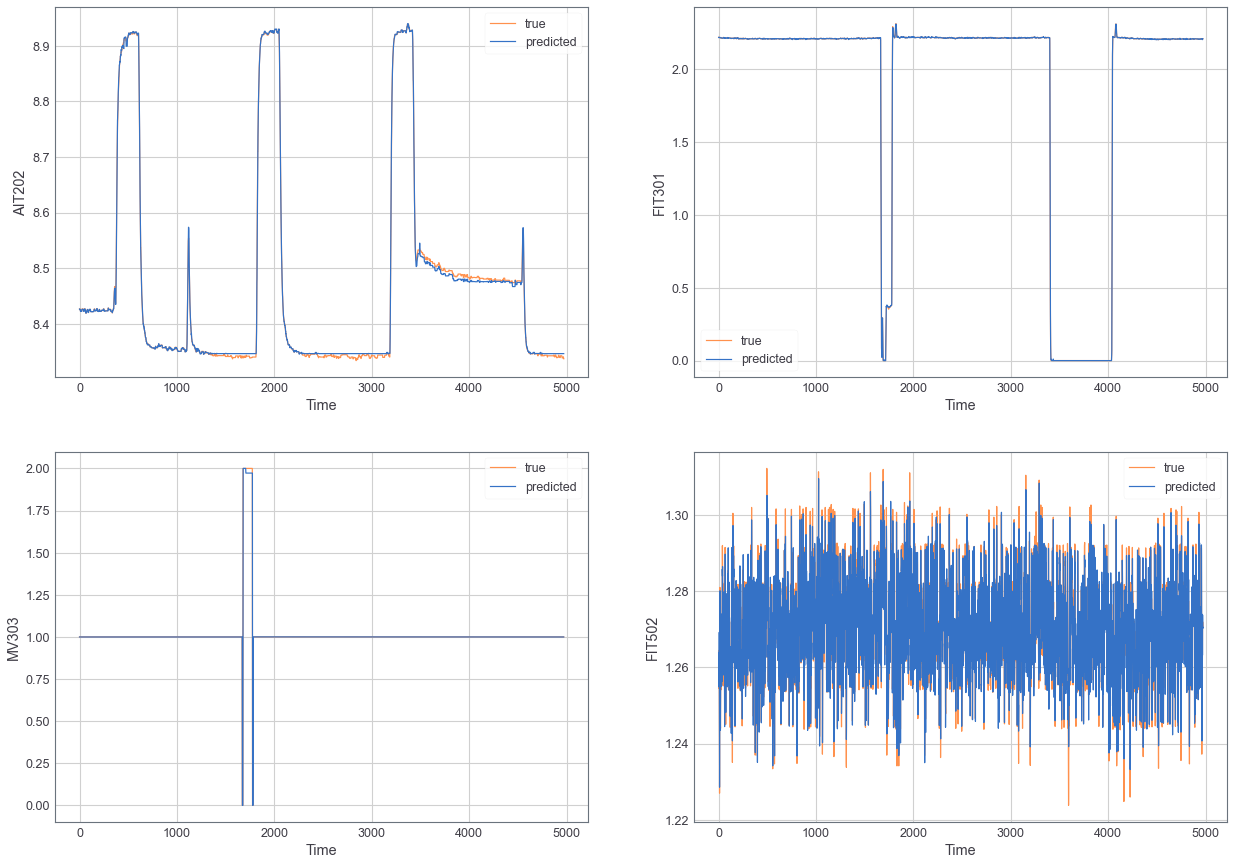

In [8]:
# applying sliding_window for ['AIT202', 'FIT301', 'MV303', 'FIT502']
columns_pred = ['AIT202', 'FIT301', 'MV303', 'FIT502']

window_size = 30
plt.figure(figsize=(21, 15))
i = 1
for col in columns_pred:
    # applying sliding window on training data set
    training_col = training_signals.loc[10000:20000, col].copy()
    sw_training_col = sliding_window(
        training_col, window_size=window_size, stride=1)
    col_x = sw_training_col[:, :window_size-1]
    col_y = sw_training_col[:, window_size-1]
    # model fitting for training data set
    rfr = RandomForestRegressor().fit(col_x, col_y)

    # applying sliding window on testing data set
    tesing_col = training_signals.loc[20000:25000, col].copy()
    sw_testing_col = sliding_window(
        tesing_col, window_size=window_size, stride=1)
    test_col_x = sw_testing_col[:, :window_size-1]
    test_col_y = sw_testing_col[:, window_size-1]
    # model prediction for testing data set
    test_col_pred = rfr.predict(test_col_x)

    # plotting for four signals
    plt.subplot(2, 2, i)
    i += 1
    plt.plot(np.arange(len(test_col_y)), test_col_y, color='y')
    plt.plot(np.arange(len(test_col_pred)), test_col_pred, color='b')
    plt.legend(['true', 'predicted'])
    plt.xlabel('Time')
    plt.ylabel(col)
print("\n Figure5: the prediction of four signals after applying sliding windows")
plt.show()

### 1b. Answers to the three questions

## 2. LOF task – 1/2 A4 – Mingyu Gao

In [9]:
train_X = training_signals.copy() # signals of training data set
train_y = training_label.copy() # labels of training data set
test_X = testing_signals.copy() # signals of testing data set
test_X.rename(columns=lambda x: x.strip(), inplace=True) # remove spaces
test_y = testing_label.copy() # labels of testing data set

### 2a. Plot LOF scores

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [04:46<00:00, 19.11s/it]


 Figure6: relation between number of outliers and number of nearest neighbours


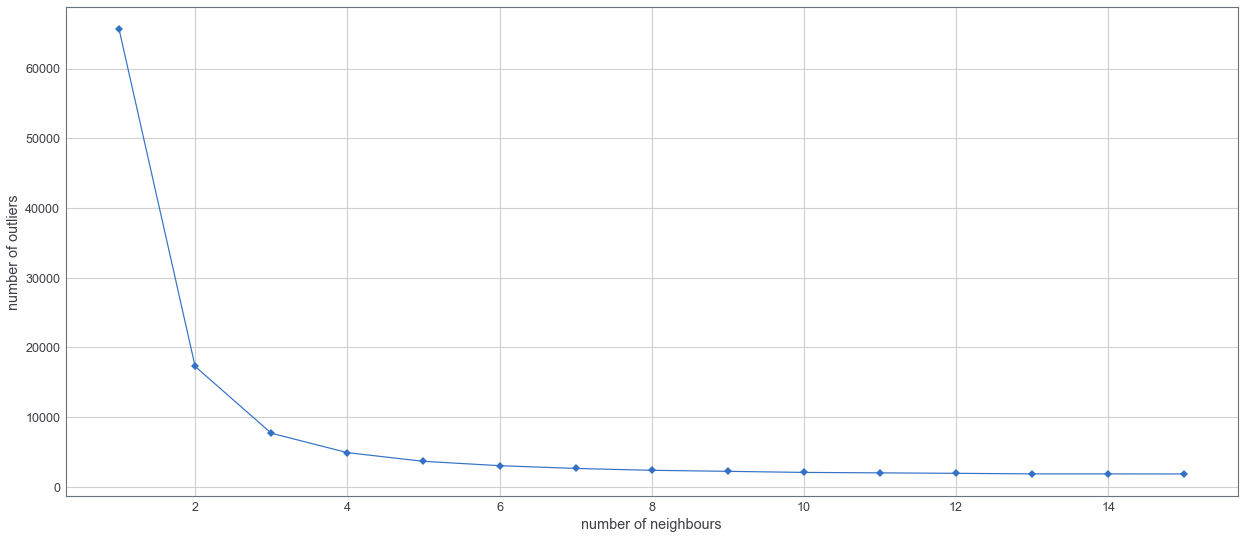

In [10]:
count_outlier = list()

for nn in tqdm(range(1,15+1)):
    # visualize the relation between number of outliers and number of nearest neighbours in training data set
    lof = LocalOutlierFactor(n_neighbors=nn,
                             algorithm='kd_tree',
                             leaf_size=30, 
                             novelty=False, 
                             n_jobs=-1)
    training_result = lof.fit_predict(train_X)
    count_outlier.append(np.sum(training_result == -1))
print("\n Figure6: relation between number of outliers and number of nearest neighbours")
plt.figure(figsize=(21,9))
plt.plot(np.arange(1,15+1), count_outlier, "-D")
plt.ylabel("number of outliers")
plt.xlabel("number of neighbours")
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:27<00:00, 51.84s/it]



 Figure7: the anomalous points found by LOF in signals - 'FIT502', 'PIT502', 'LIT301', 'LIT401' 


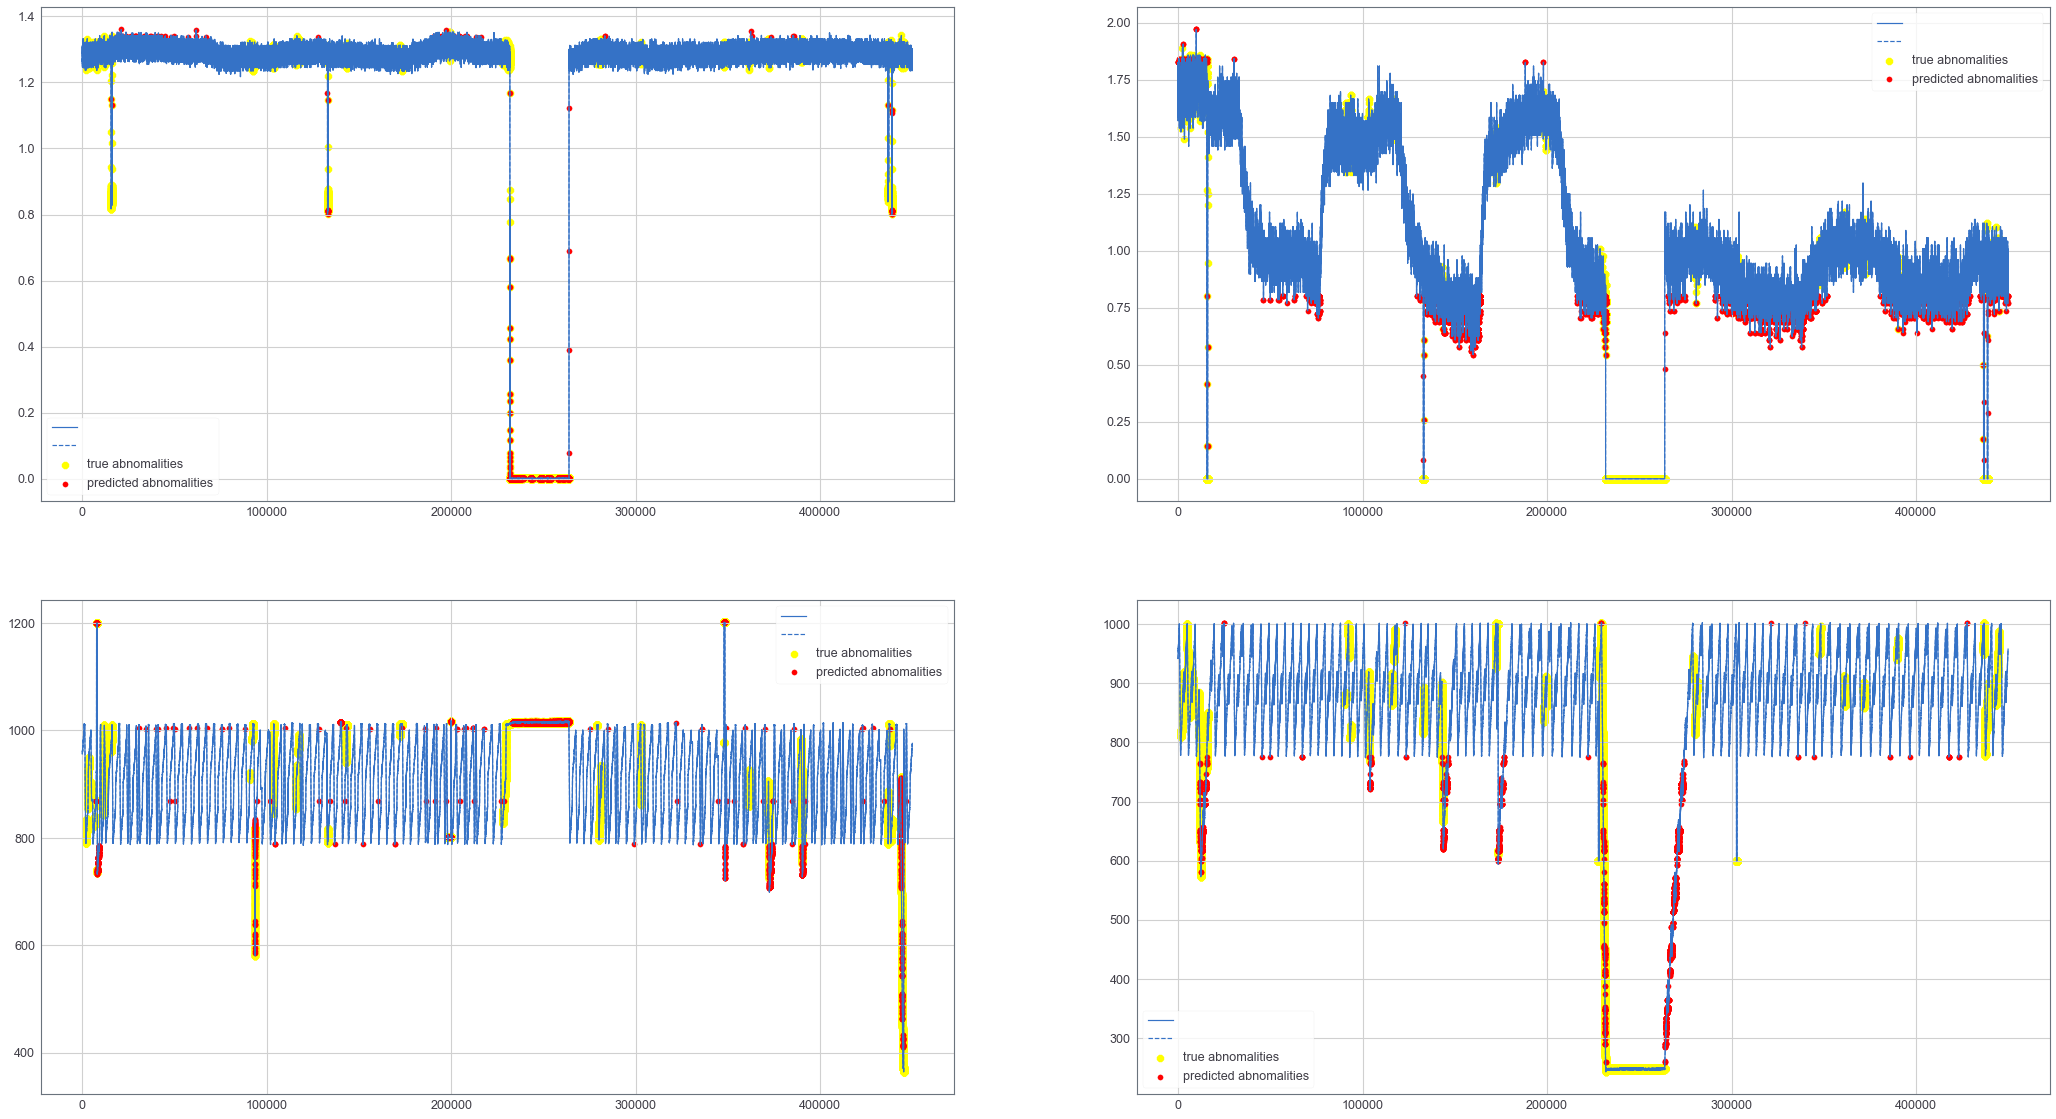

In [11]:
# signals for applying LOF model
selected_signals = ['FIT502', 'PIT502', 'LIT301', 'LIT401']
y_pred_all = []
# list of nearest neighbours for each signal
nn = [15, 15, 15, 15]

plt.figure(figsize=(36, 20))
i = 1
for signal in tqdm(selected_signals):
    # model fitting for four signals
    lof = LocalOutlierFactor(n_neighbors=nn[i-1],
                             algorithm='kd_tree',
                             leaf_size=100,
                             metric='minkowski',
                             p=1,
                             contamination="auto",
                             novelty=True,
                             n_jobs=-1)
    y_pred = lof.fit(train_X[signal].values.reshape(-1, 1)).predict(
        test_X[signal].values.reshape(-1, 1))

    plt.subplot(2, 2, i)
    i += 1
    plt.plot(test_X[signal])
    # selecting the anomolous points in the testing data set based on label
    true_abn = np.where(test_y == 1)[0]
    # selecting the anomoulos points in the predicting data set detected by LOF
    pred_abn = np.where(y_pred == -1)[0]
    plt.plot(test_X[signal], '--b')
    # original anomolous points marked with yellow
    plt.scatter(true_abn,
                test_X.loc[true_abn, [signal]],
                c='yellow',
                marker='8',
                s=60)
    # predicted anomolous points marked with red
    plt.scatter(pred_abn,
                test_X.loc[pred_abn, [signal]],
                c='red',
                marker='o',
                s=30)
    y_pred_all.append(y_pred)
    plt.legend(['', '', 'true abnomalities', 'predicted abnomalities'])
print("\n Figure7: the anomalous points found by LOF in signals - 'FIT502', 'PIT502', 'LIT301', 'LIT401' ")
plt.show()


 Figure8: confusion matrix of LOF model


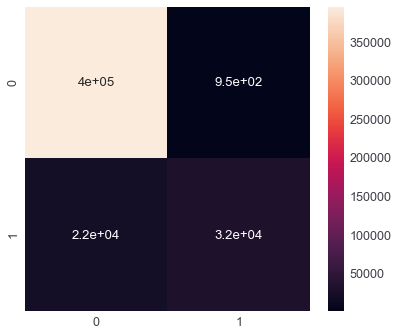

In [12]:
# plot the confusion matrix of LOF model for comparison task
# choose anomalous points detected by LOF model
test_pred = y_pred_all[2] == -1
cm = confusion_matrix(test_y, test_pred)
print("\n Figure8: confusion matrix of LOF model")
f = sns.heatmap(cm, annot=True)

### 2b. Analysis and answers to the questions

#### Do you see large abnormalities in the training data?
The number of abnormalities relies on the number of neighbors that are chosen to estimate a sample point. If the neighbors are few, a great number of sample points will be sentenced to be outliers, but with the increase of neighbors, the number of abnormalities in the training set becomes less. The number of neighbors cannot be set too large, as it will be less sensitive to the truth outliers in the testing set. However, the number cannot be set too small either, as it will become too sensitive to the local changes.

#### Can you explain why these occur?
Even in the data set where no abnormalities are included, some segments in the signals may still not rigorously follow the normal behaviors. In consequence, some points may form outlier clusters in which points are normal but are abnormal globally when taking all segments into consideration.

#### It is best to remove such abnormalities from the training data since you only want to model normal behavior?
If a pattern that is normal shows abnormal in the training set, when a similar pattern appears in the testing set, the similar one would be predicted as an abnormality because the pattern originally in the training set is sentenced to be abnormal. If the same pattern is removed from the training set, when a similar pattern appears in the testing set, this coming one would be predicted as an abnormality because the model has no idea about this "new" pattern. Therefore, deleting the abnormalities in the training set seems to impact less on the predictions.

#### What kind of anomalies can or can you not detect using LOF?
LOF can detect point anomalies by measuring the local deviation of density for a given sample with respect to its neighbors. Point anomaly is defined as "*A single instance of data that is anomalous since it deviates largely from the rest of the data points*" which is consistent with the measurement of LOF - *how isolated the object is with respect to the surrounding neighborhood*.

## 3. PCA task – 1/2 A4 – Mingyu Gao

In [13]:
train_X = training_signals.copy() # signals in training data set
train_y = training_label.copy() # labels in training data set
test_X = testing_signals.copy() # signals in testing data set
test_y = testing_label.copy() # labels in testing data set

### 3a. Plot PCA residuals

In [14]:
# decide n_components
# to normalize the training data
normalizer = Normalizer().fit(train_X)
train_X_norm = normalizer.transform(train_X)

res = []
for n_components in np.arange(5, 25+1):
    # pca
    pca = PCA(n_components=n_components).fit(train_X_norm)

    # pca forward transform
    train_X_pca = pca.transform(train_X_norm)

    # pca backward transform
    train_X_invpca = pca.inverse_transform(train_X_pca)

    # compute residual
    res.append(np.linalg.norm(train_X_norm - train_X_invpca, ord=2, axis=1))
    
    print('>', end='')

>>>>>>>>>>>>>>>>>>>>>


 Figure9: residual of different components


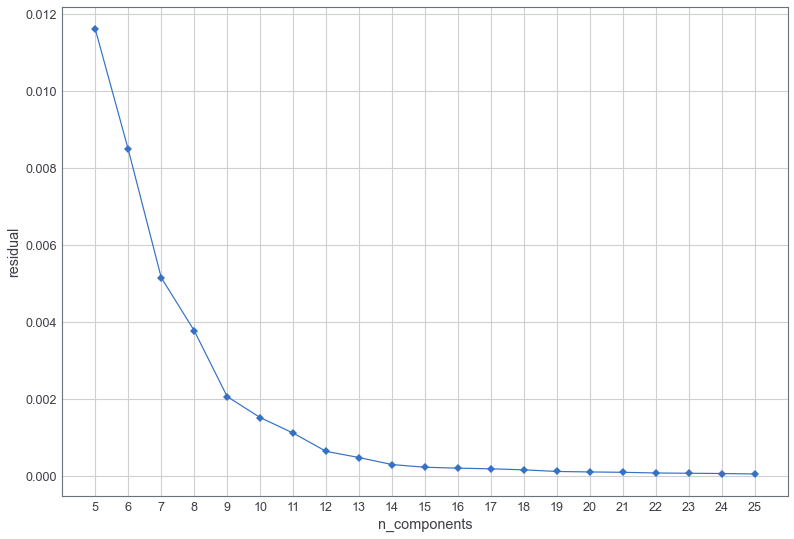

In [15]:
# plot residual ~ n_components
plt.figure(figsize=(13, 9))
plt.plot(np.arange(5, 25+1), np.mean(res, axis=1), '-D')
plt.xticks(ticks=np.arange(5, 25+1))
plt.ylabel('residual')
plt.xlabel('n_components')
print("\n Figure9: residual of different components")
plt.show()


 Figure10: confusion matrix of LOF model


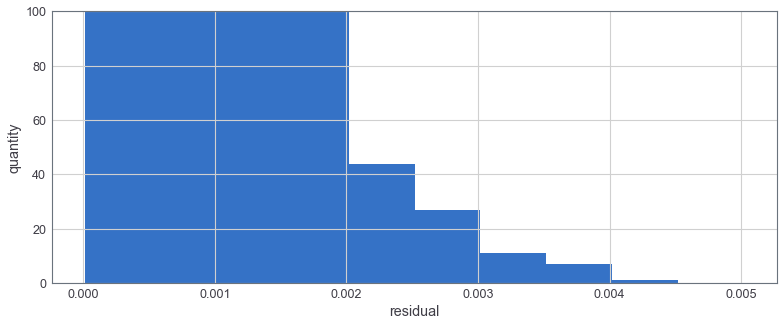

In [16]:
# box-plot to visualize the distribution
plt.figure(figsize=(13, 5))
plt.hist(res[12], range=[np.min(res[12]), np.max(res[12])+0.001])
plt.xlabel('residual')
plt.ylabel('quantity')
plt.ylim([0,100])
print("\n Figure10: confusion matrix of LOF model")
plt.show()

In [17]:
# define the value of component and threshold based on figure 9 and 10
n_components = 12
threshold = 0.004


 Figure11: confusion matrix of PCA model


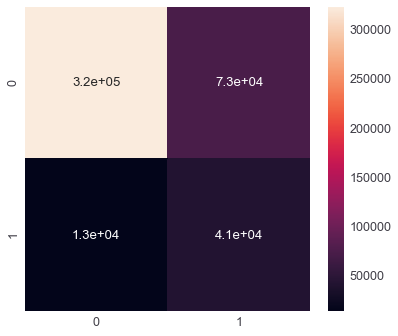

In [18]:
# build pca
pca = PCA(n_components=n_components).fit(train_X_norm)

# normalize testing data
test_X_norm = Normalizer().transform(test_X)

# forward pca
test_X_pca = pca.transform(test_X_norm)

# backward pca
test_X_invpca = pca.inverse_transform(test_X_pca)

# prediction
test_pred = np.linalg.norm(test_X_norm-test_X_invpca, ord=2, axis=1) > threshold

# confusion matrix
cm = confusion_matrix(test_y, test_pred)
print("\n Figure11: confusion matrix of PCA model")
f = sns.heatmap(cm, annot=True)

### 3b. Analysis and answers to the questions

#### Do you see large abnormalities in the training data? Can you explain why these occur?
Using PCA to detect the anomaly is quite similar to auto-encoder. PCA, trained by the training set, is used for reducing the feature dimensions of samples and recovering them back. If the samples can be recovered from the loss compression, they obey normal structure and are normal data; otherwise, they are abnormalities. In this situation, the recovering threshold is quite important to decide whether the recovered points belong to normal ones. If the threshold is set too small, it will have a considerable amount of abnormalities in the training data. Thus, in order to make the judgment of anomaly fair, the threshold should be set suitable large. 

#### It is best to remove such abnormalities from the training data since you only want to model normal behavior?
If the abnormalities are removed from the training data, we will have no idea where to put the threshold. The abnormalities in the training data tell people which points cannot be recovered back. 

#### What kind of anomalies can or can you not detect using PCA?
PCA detects point outliers that have an obviously different variance than the regular distribution in the direction of the principal components.

## 4. ARMA task – 1/2 A4 - Yuhang Tian

In [19]:
# signals for ARMA
ARMA_SIGNALS = ['AIT504', 'LIT101', 'LIT301', 'AIT202', 'AIT402']

train_X = training_signals[ARMA_SIGNALS].copy()
train_y = training_label.copy()
test_X = testing_signals[ARMA_SIGNALS].copy()
test_y = testing_label.copy()

### 4a. Print relevant plots and/or metrics to determine the parameters.


 Figure12: PACF and ACF plot for signals
AIT504


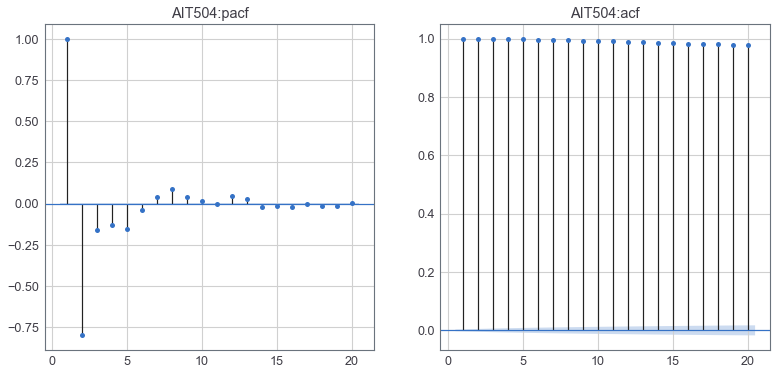


 Figure12: PACF and ACF plot for signals
LIT101


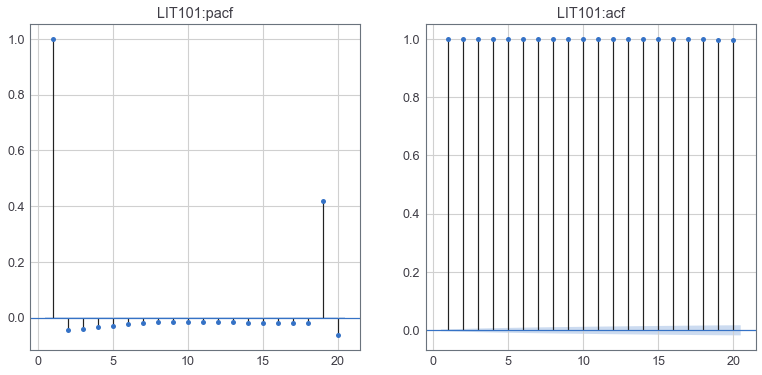


 Figure12: PACF and ACF plot for signals
LIT301


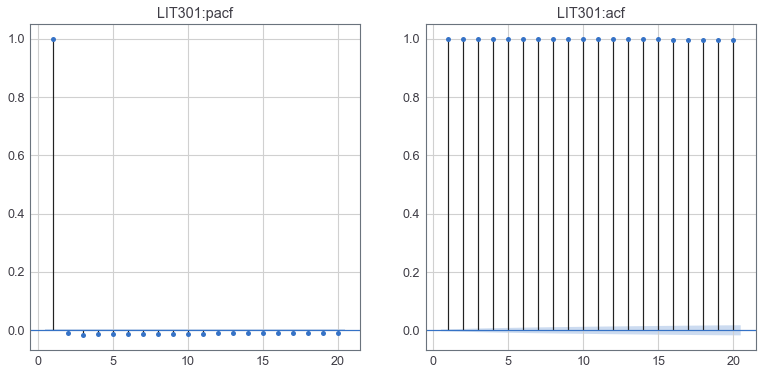


 Figure12: PACF and ACF plot for signals
AIT202


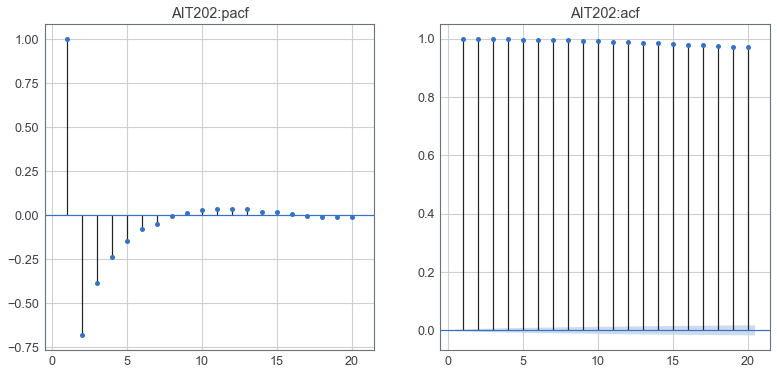


 Figure12: PACF and ACF plot for signals
AIT402


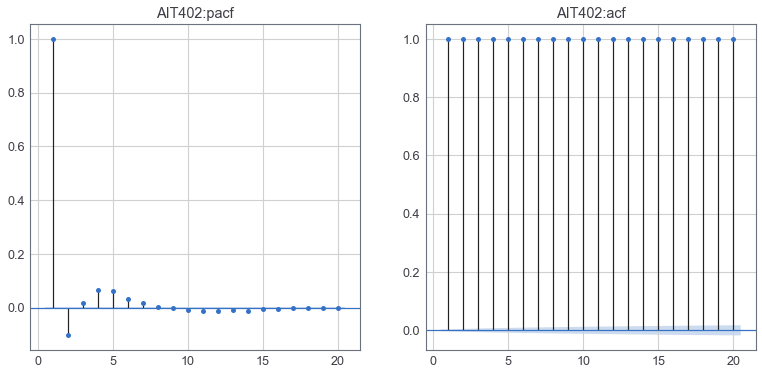

In [20]:
for signal in ARMA_SIGNALS:
    print("\n Figure12: PACF and ACF plot for signals")
    print(signal)
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
    plot_acf(train_X[signal], lags=20, zero=False, ax=ax2, title=signal+":acf")
    plot_pacf(train_X[signal], lags=20, zero=False, ax=ax1, title=signal+":pacf")
    plt.show()

In [21]:
# select the model with lowest aic
p_range = range(0,3) 
q_range = range(0,3) 
d_range = range(0,2)
# the list to store the p,d,q value for five signals
best_order = []

for signal in ARMA_SIGNALS:
    sub_train_X = train_X[signal].copy()
    aic = np.inf 
    order = None
    arima = None
    for i in p_range:
        for j in q_range:
            for d in d_range:
                # to select the smallest aic 
                    temp_model = ARIMA(sub_train_X[12000:16000], order=(i,d,j)).fit()
                    temp_aic = temp_model.aic
                    if temp_aic < aic:
                        aic = temp_aic
                        order = (i, d, j)
                        arima = temp_model
    print('Best order for '+signal, order)
    best_order.append(order)

Best order for AIT504 (2, 1, 1)
Best order for LIT101 (2, 1, 2)
Best order for LIT301 (2, 1, 2)
Best order for AIT202 (2, 1, 2)
Best order for AIT402 (2, 1, 2)


In [22]:
# To make things simpler, the best order is set to (2,1,2)
best_order = (2,1,2)

### 4b. Plots to study the detected anomalies


 Figure13: residual curve
AIT504


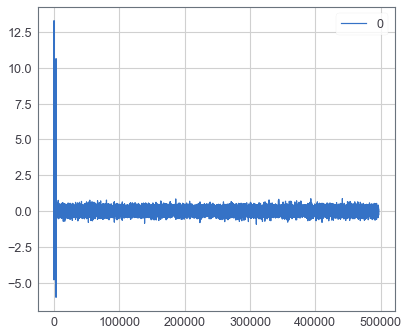

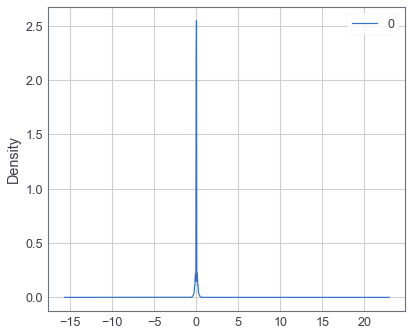

                   0
count  496800.000000
mean        0.000025
std         0.085668
min        -6.028413
25%        -0.000002
50%         0.000000
75%         0.000002
max        13.303102
LIT101


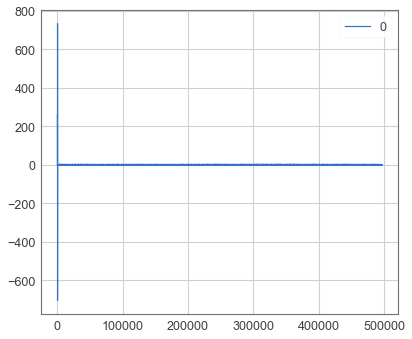

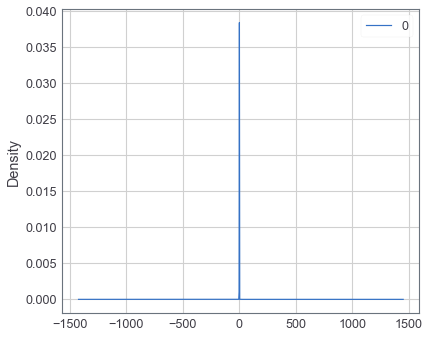

                   0
count  496800.000000
mean        0.000981
std         1.558202
min      -705.081823
25%        -0.264925
50%        -0.000341
75%         0.261990
max       733.255081
LIT301


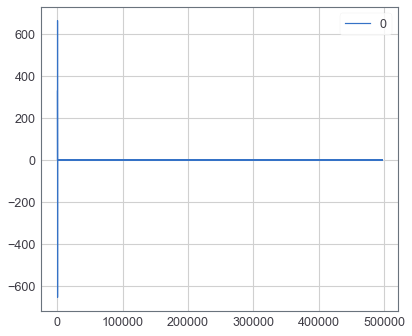

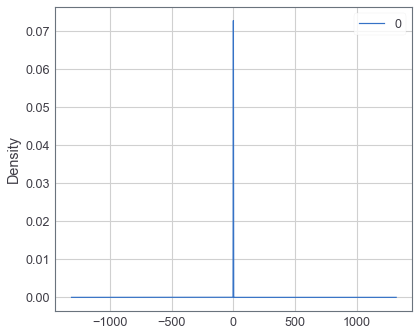

                   0
count  496800.000000
mean        0.001067
std         1.427366
min      -652.981882
25%        -0.185509
50%        -0.005362
75%         0.178418
max       662.313903
AIT202


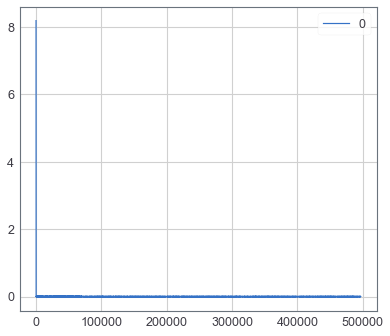

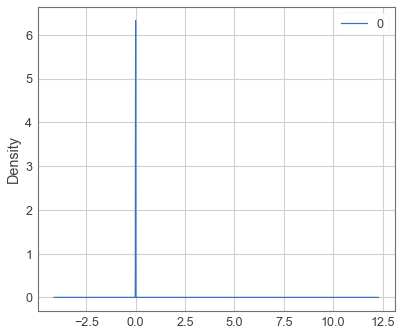

                   0
count  496800.000000
mean        0.000017
std         0.011656
min        -0.024316
25%        -0.000087
50%         0.000000
75%         0.000089
max         8.190080
AIT402


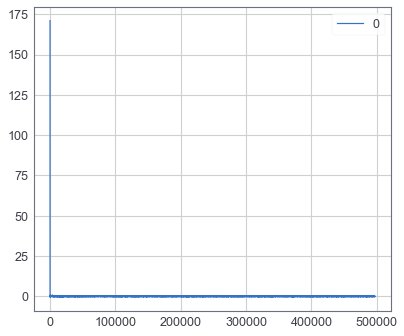

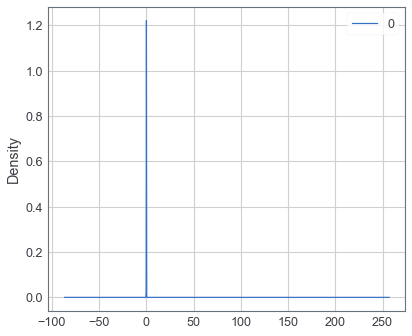

                  0
count  4.968000e+05
mean   3.120006e-04
std    2.466186e-01
min   -7.283536e-01
25%   -4.789207e-04
50%    9.947598e-14
75%    5.765505e-04
max    1.710587e+02


In [23]:
print("\n Figure13: residual curve")
for signal in ARMA_SIGNALS:
    print(signal)
    series = train_X[signal].copy()
    # fit model
    model = ARIMA(series, order=best_order)
    model_fit = model.fit()
    # summary of fit model
    # print(model_fit.summary())
    # line plot of residuals
    residuals = pd.DataFrame(model_fit.resid)
    residuals.plot()
    plt.show()
    # density plot of residuals
    residuals.plot(kind='kde')
    plt.show()
    # summary stats of residuals
    print(residuals.describe())

The following cell is the training and predicting process which is time-consuming. You can uncomment it and run by yourself.

In [24]:
# for signal in ARMA_SIGNALS:
#     print(signal)
#     sub_train_X = train_X[signal].copy()
#     sub_test_X = test_X[signal].copy()
#     train, test = sub_train_X[10000:20000].values, sub_test_X[11410-250:11410+50].values
#     label = test_y[11410-250:11410+50]
#     history = [x for x in train]
#     predictions = list()
#     # walk-forward validation
#     for t in tqdm(range(len(test))):
#         model = ARIMA(history, order=best_order)
#         model_fit = model.fit()
#         output = model_fit.forecast()
#         yhat = output[0]
#         predictions.append(yhat)
#         obs = test[t]
#         history.append(obs)
# #         print('predicted=%f, expected=%f' % (yhat, obs))
#     # evaluate forecasts
#     np.save("./arma/prediction_"+signal+".npy", predictions)
#     rmse = np.sqrt(mean_squared_error(test, predictions))
#     print('Test RMSE: %.3f' % rmse)
#     # plot forecasts against actual outcomes
#     plt.figure(figsize=(13,6))
#     plt.plot(test, "--b")
#     plt.plot(predictions, '-.r')
#     plt.title("Evaluation ARIMA")
#     plt.xlabel('Time')
#     plt.ylabel('Value')
#     plt.legend(['original', 'predicted'])
#     plt.show()


 Figure14: plot prediction for each signal from point 11170 to point 11460


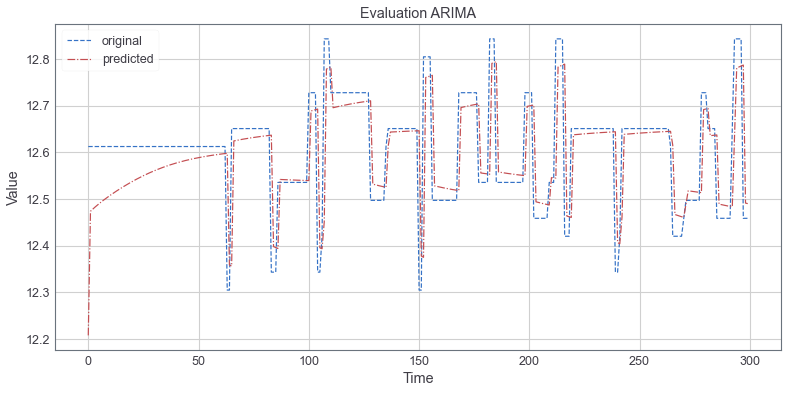

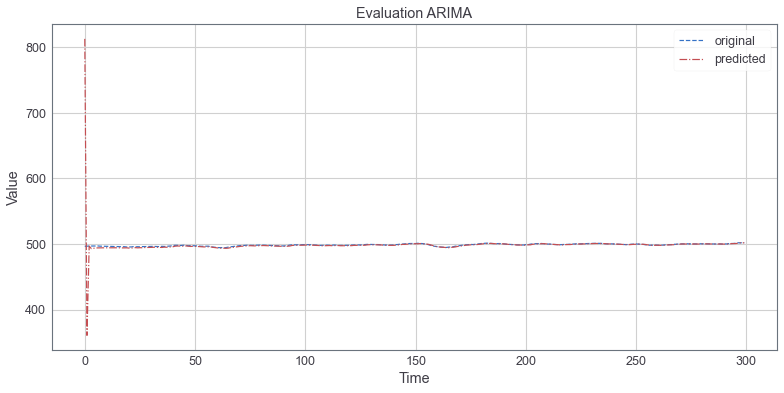

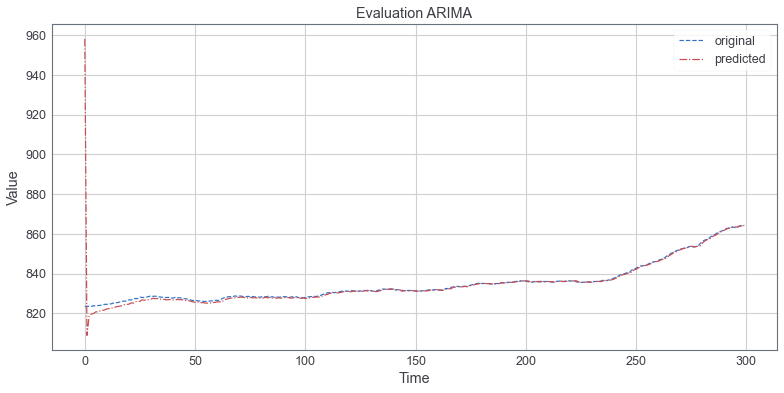

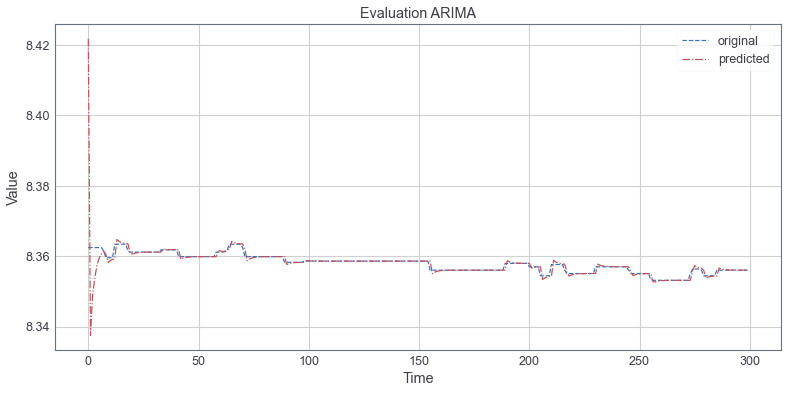

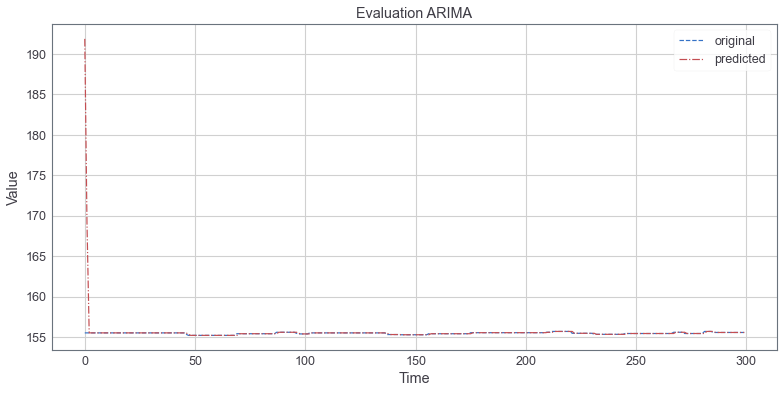

In [25]:
print("\n Figure14: plot prediction for each signal from point 11170 to point 11460")
for signal in ARMA_SIGNALS:
    # load arma data from the trained file
    temp_signal = np.load('./arma/prediction_' + signal + '.npy')
    sub_test_X = test_X[signal].copy()
    test = sub_test_X[11410-250:11410+50].values
    # plot forecasts against actual outcomes
    plt.figure(figsize=(13, 6))
    plt.plot(test, "--b")
    plt.plot(temp_signal, '-.r')
    plt.title("Evaluation ARIMA")
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend(['original', 'predicted'])
    plt.show()

We plot the true anomalous points and predicted anomalous points for comparison task. The region from point 11160 to 11460 contains 250 negative and 50 positive points.

In [26]:
# load data from trained data as training is time consuming
selected_signal = np.load('./arma/prediction_AIT504.npy')
selected_original = test_X.loc[11410-250:11410+50-1, ['AIT504']].values.reshape(-1,)
# the threshold is to distinguish outliers
threshold = 0.01
selected_signal_pred = (selected_signal - selected_original) > threshold
selected_signal_label = test_y[11410-250:11410+50]
# check the confusion matrix for the 300 points tested by ARMA
confusion_matrix(selected_signal_label, selected_signal_pred)

array([[190,  60],
       [ 27,  23]], dtype=int64)


 Figure15: true and predicted anomalous points from point 11170 to point 11460


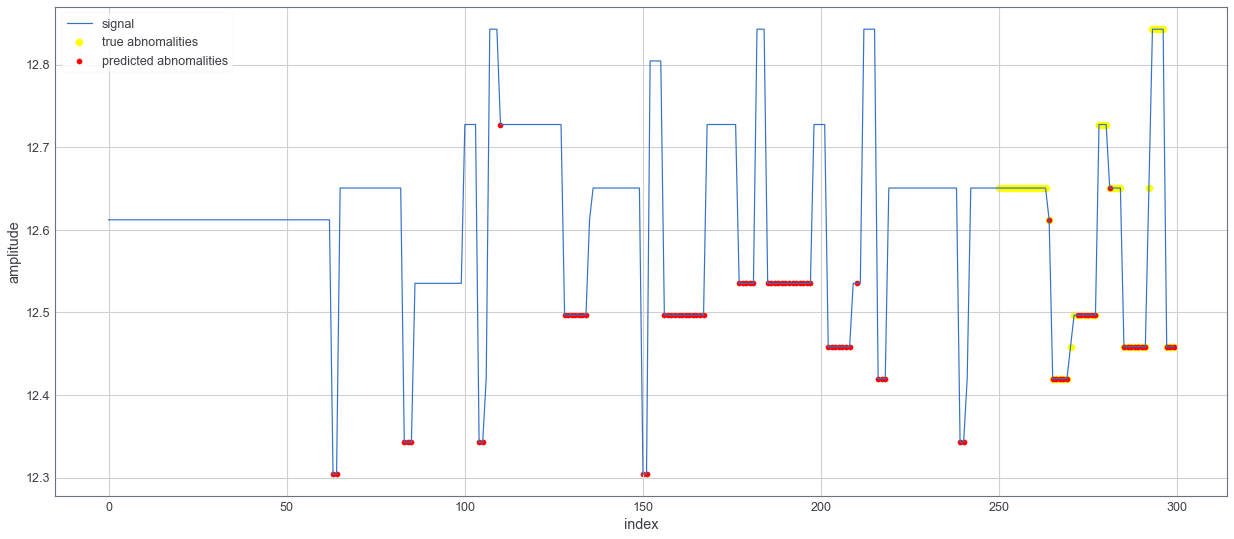

In [27]:
print("\n Figure15: true and predicted anomalous points from point 11170 to point 11460")
pred_abn = np.where(selected_signal_pred==1)[0]
true_abn = np.where(selected_signal_label==1)[0]
plt.figure(figsize=(21,9))
plt.plot(selected_original)
plt.scatter(true_abn, selected_original[true_abn], c='yellow', marker='8', s=60)
plt.scatter(pred_abn, selected_original[pred_abn], c='red', marker='o', s=30)
plt.xlabel('index')
plt.ylabel('amplitude')
plt.legend(['signal', 'true abnomalities', 'predicted abnomalities'])
# plt.savefig('./figures/arima_res.png', dpi=600)
plt.show()

### 4c. Analysis and answers to the questions

#### What kind of anomalies can / can you not detect using ARMA models?
ARMA has the ability to identify contextual anomalies because ARMA regress on previous values then uses them to predict the next value. According to its results, we observed that when the tendency of the predicting signal gradually changes, ARMA can abide by the signal well, but when there is a sudden change, it cannot perfectly catch and follow this change. Since ARMA is quite sensitive to local change, it is suitable for detecting contextual anomalies. 

#### Which sensors can be modeled effectively using ARMA?
The prediction using ARMA is quite time-consuming. In this task, we adopted ARMA as an off-line model - given training set and to predict testing set. However, we think ARMA is much better to be designed as an online model. ARMA is quite suitable for the sensors which monitor the moderately changing signals such as AIT402, AIT501, and AIT502. Other signals like MV301 are not appropriate for it, since it often alarms abnormalities for them when observes dramatic changes. 

## 5. N-gram task – 1/2 A4 - Yuhang Tian

In [28]:
# the function for discretizing data 
def dicretize_data(signal, discretize_groups):
    '''
    signal: the selected signal for discretizing
    discretize_groups: the input data
    '''
    # Initiliaze arrays
    label_classes = []
    step_sizes = []

    # Compute min and max value of signal to compute the stepsize
    min_value = min(signal)
    max_value = max(signal)
    step_size = (max_value - min_value) / discretize_groups

    bins = []
    bins.append(min_value)
    # Create bins
    for i in range(discretize_groups):
        label_classes.append(i)
        bins.append(bins[i] + step_size)

    # Use digitize method to discretize the signal
    return np.digitize(signal, bins), bins

### 5a. Visualise discretization

In [29]:
# function for plotting discretized data 
def plot_discretize(ngram_signal):
    '''
    ngram_signal: the signal for plotting discretized data
    '''
    train_X = training_signals[ngram_signal].copy()
    train_y = training_label.copy()
    test_X = testing_signals[ngram_signal].copy()
    test_y = testing_label.copy()
    plt.figure(figsize=(21,9))
    plt.title("Training Set")
    plt.subplot(121)
    plt.plot(np.unique(train_X,return_counts=True)[0], np.unique(train_X,return_counts=True)[1])
    plt.xlabel("values")
    plt.ylabel('counts')
    plt.title("original")
    train_X_discrete, train_bins = dicretize_data(train_X, int(len(set(train_X))/100))
    plt.subplot(122)
    plt.plot(np.unique(train_X_discrete,return_counts=True)[0], np.unique(train_X_discrete,return_counts=True)[1])
    plt.xlabel("values")
    plt.ylabel('counts')
    plt.title('after dicretized')

    plt.figure(figsize=(21,9))
    plt.title("Testing Set")
    plt.subplot(121)
    plt.plot(np.unique(test_X,return_counts=True)[0], np.unique(test_X,return_counts=True)[1])
    plt.xlabel("values")
    plt.ylabel('counts')
    plt.title("original")
    test_X_discrete = np.digitize(test_X, train_bins)
    # train_X_discrete, test_bins = dicretize_data(test_X, int(len(set(test_X))/100))
    plt.subplot(122)
    plt.plot(np.unique(test_X_discrete,return_counts=True)[0], np.unique(test_X_discrete,return_counts=True)[1])
    plt.xlabel("values")
    plt.ylabel('counts')
    plt.title('after dicretized')
    plt.show()

In [30]:
ngram_signals = ['LIT101', 'LIT301', 'AIT202', 'AIT402', 'AIT503']


 Figure16: plot original and discretized data for each signal


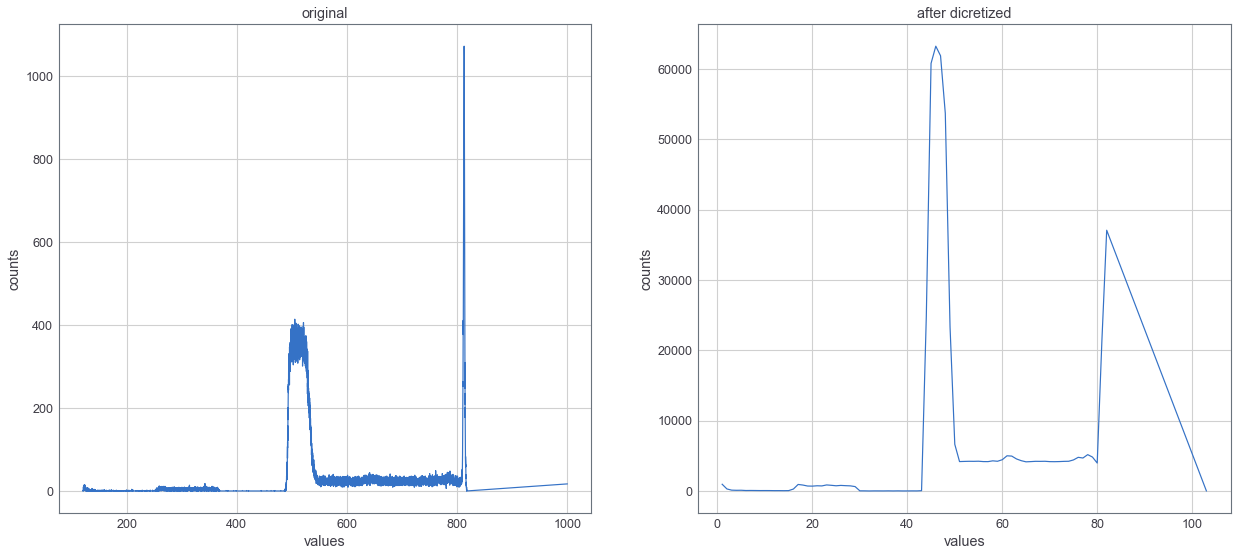

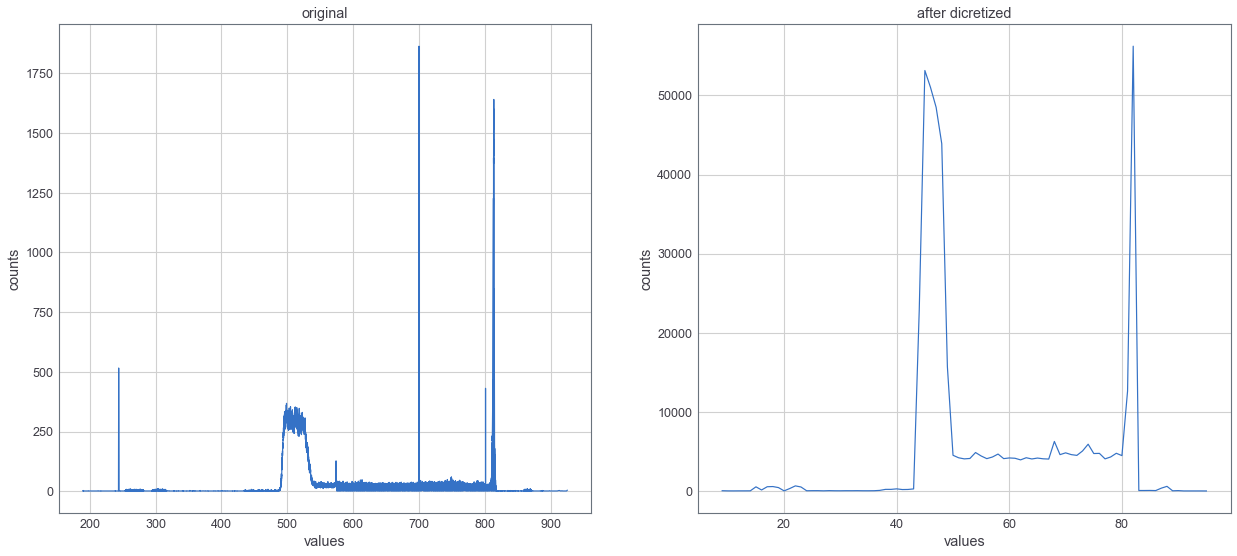

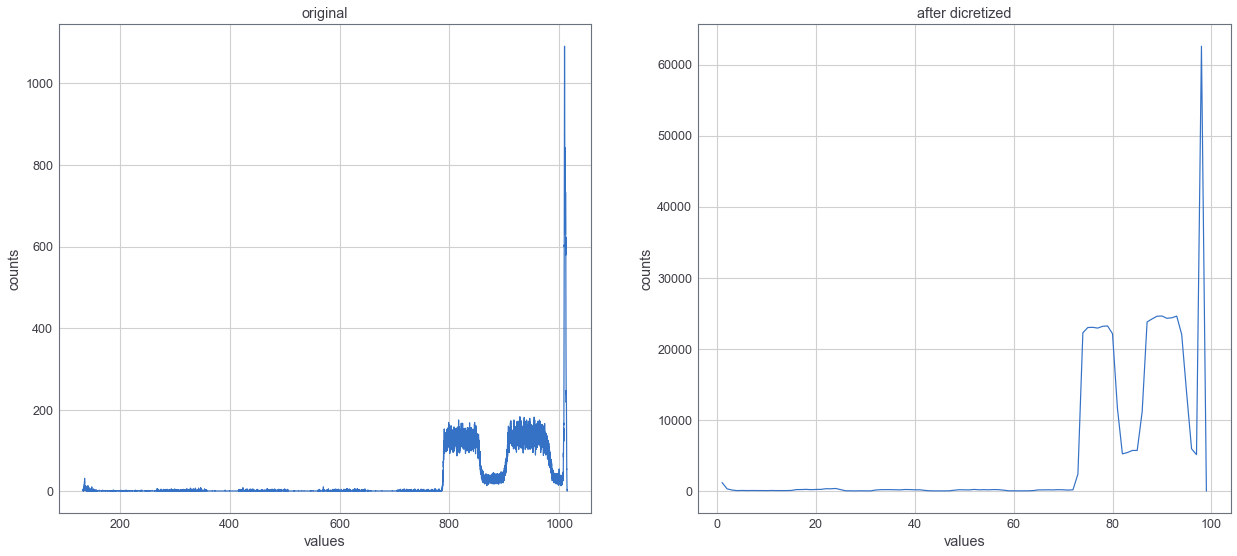

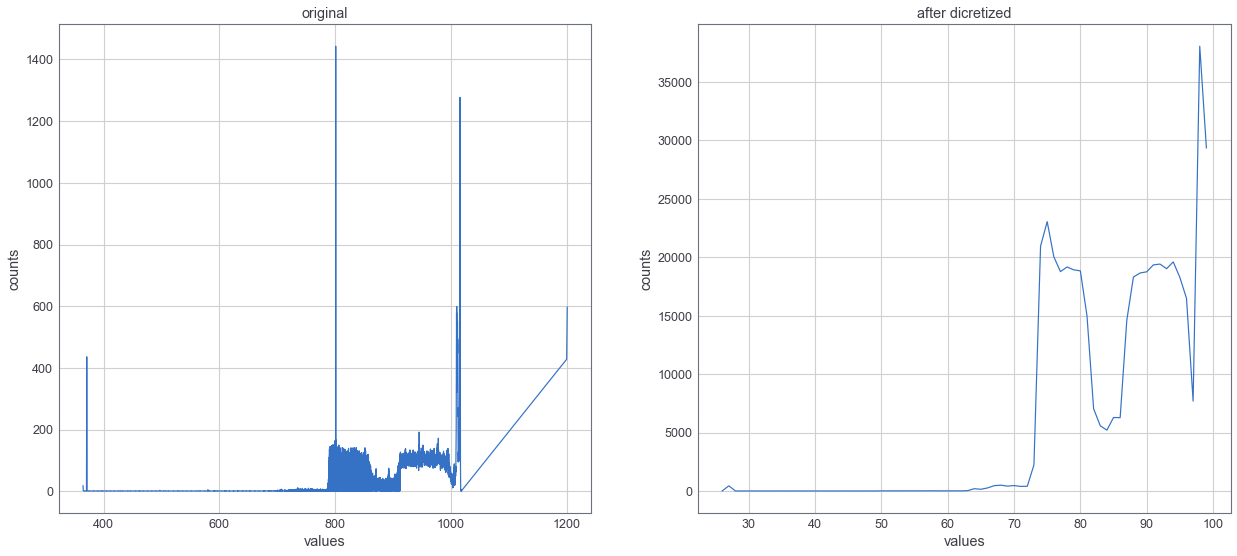

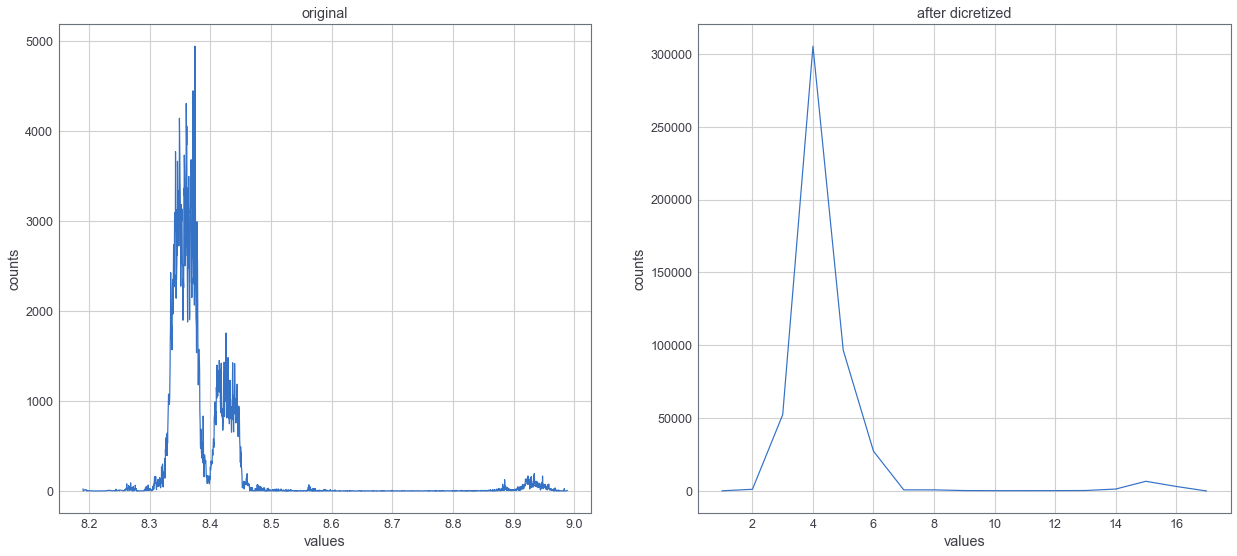

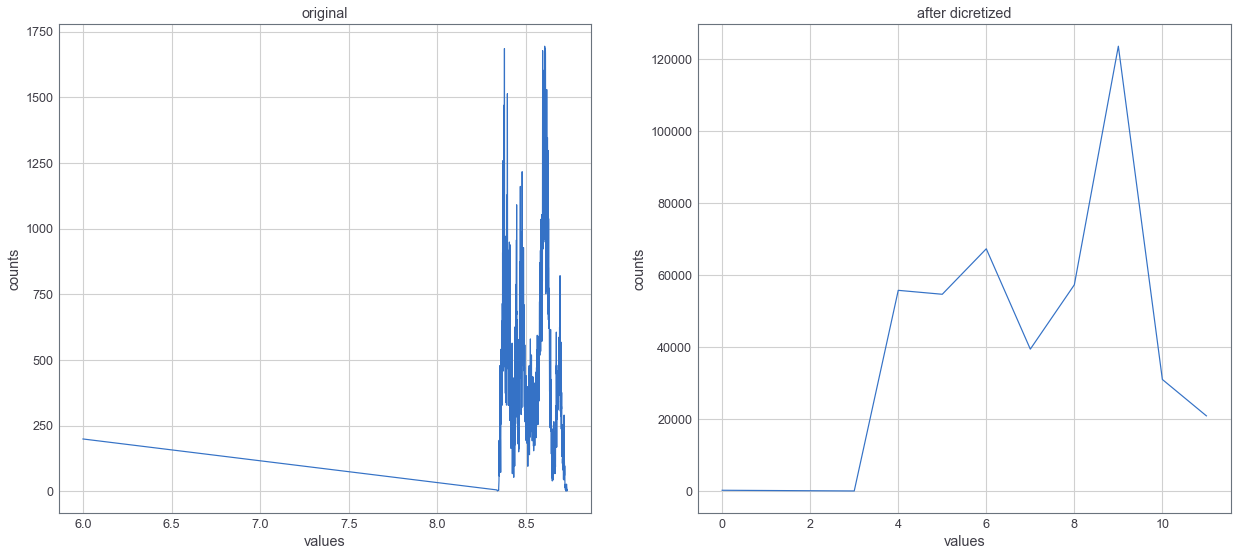

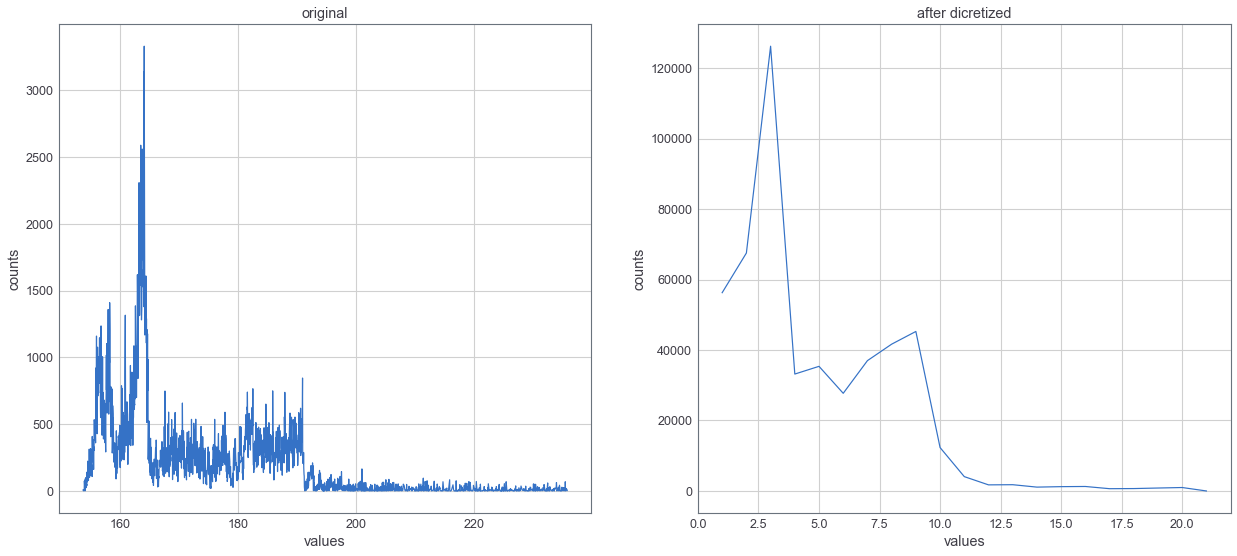

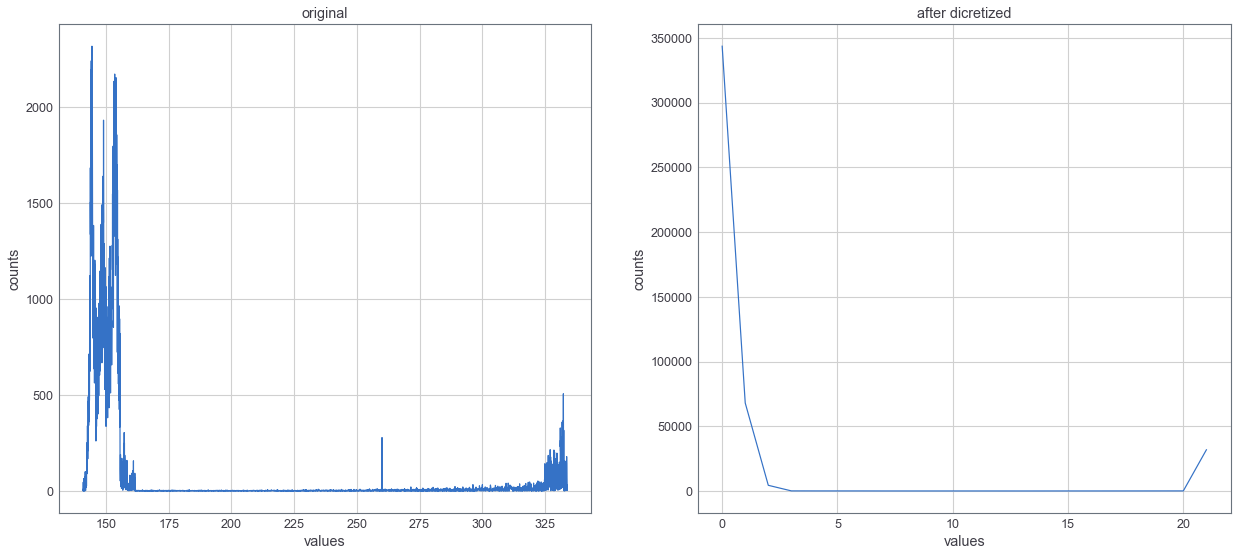

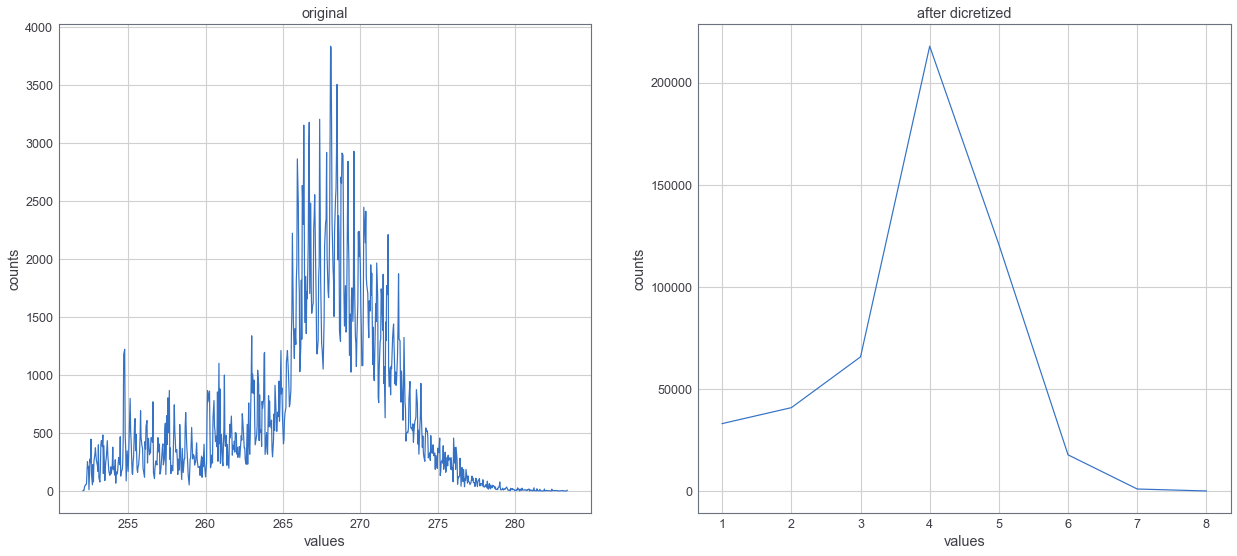

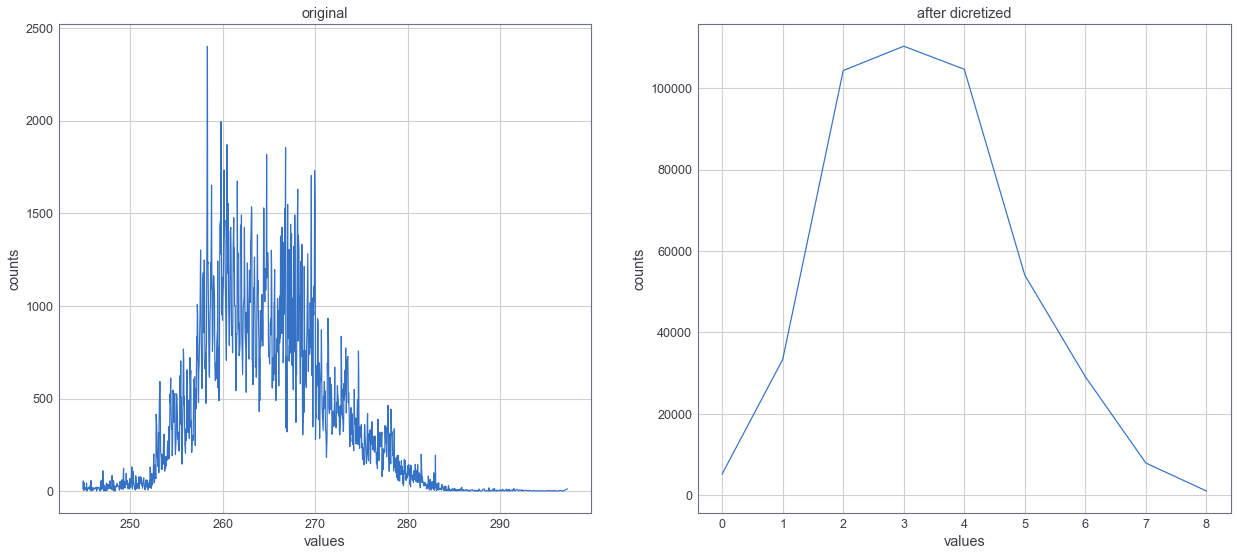

In [31]:
print("\n Figure16: plot original and discretized data for each signal")
for ngram_signal in ngram_signals:
    plot_discretize(ngram_signal)

In [32]:
# function for compute ngram_matrix
# Computes the occurences of each n-gram for the provided amount of sliding windows
def compute_ngram_matrix(signal, sliding_windows, n, stepsize):
    '''
    signal: signal for plotting ngram matriix
    sliding_windows: the number of points in one sliding window
    n: the number of grams
    stepsize: the stepsize of sliding window
    '''
    # Initialize matrix with amounnt of rows equal to the amount of sliding windows     
    matrix = pd.DataFrame(np.zeros(len(sliding_windows)))
    # Initialize counters     
    count_sliding_window = 0
    
    # For each sliding window length compute the occurences of the n-grams     
    for sliding_window in tqdm(sliding_windows):
        i = 0
        # Pick part of signal(depending on size of sliding window) until end of signal is reached
        while i + sliding_window <= len(signal):
            # Pick part of signal with size of sliding window
            cur_sliding_window = signal[i:i + sliding_window]
            j = 0
            # Loop through part of signal and count the n-grams until end is reached             
            while j + n <= len(cur_sliding_window):
                # Current n-gram                 
                cur_ngram = cur_sliding_window[j:j + n]
                cur_ngram_string = ''
                # Create string value of n-gram                 
                for k in cur_ngram:
                    cur_ngram_string += str(k)
                # Check if matrix already contains a column for the specific n-gram, if so, add 1 to the correct cell.
                # If not, create a column and set                  
                if cur_ngram_string not in matrix.columns:
                    matrix.loc[count_sliding_window, cur_ngram_string] = 1
                else:
                    if np.isnan(matrix.loc[count_sliding_window, cur_ngram_string]):
                        matrix.loc[count_sliding_window, cur_ngram_string] = 1
                    else:
                        matrix.loc[count_sliding_window, cur_ngram_string] += 1
                j += 1
            i += stepsize
        count_sliding_window += 1
    # To avoid NAN's, replace all NAN's with 0      
    matrix = matrix.fillna(0)
    # Delete first column(was there just for initialization of the dataframe)     
    matrix = matrix.drop(matrix.columns[0], axis=1)
    
    # Normalize all rows by their total value
    matrix = matrix.div(matrix.sum(axis=1), axis=0)
    return matrix

In [33]:
# global setting
# Intialize hyperparameters
# these parameters selected by tuning
n = 10 
stepsize = 5
sliding_windows = [10, 50, 100, 400] # it will save the best ngram matrix obtained by these four size of windows

In [34]:
def get_ngram_matrix(ngram_signal):
    '''
    ngram_signal: signal for getting ngram matrix
    '''
    
    # Compute the matrix where the row represents the size of the sliding windows and the columns the N-grams.
    # The cells in the matrix represent the occurence of the N-gram in that sliding window
    # train_matrices = {}
    # test_matrices = {}

    # For simplicity and to avoid enormous runtime, it is only done for signal
    # for signal in signals:
    train_X = training_signals[ngram_signal].copy()
    train_y = training_label.copy()
    test_X = testing_signals[ngram_signal].copy()
    test_y = testing_label.copy()
    train_X_discrete, train_bins = dicretize_data(train_X, int(len(set(train_X))/100))
    
    train_ngram_matrix = compute_ngram_matrix(train_X_discrete, sliding_windows, n, stepsize)
    # save train_ngram_matrix
    train_ngram_matrix.to_csv('./ngramdata/train_ngram_matrix_'+ngram_signal+'.csv')
    
    test_X_discrete, test_bins = dicretize_data(test_X, int(len(set(test_X))/100))
    test_ngram_matrix = compute_ngram_matrix(
    test_X_discrete, sliding_windows, n, stepsize)
    # save test_ngram_matrix
    test_ngram_matrix.to_csv('./ngramdata/test_ngram_matrix_'+ngram_signal+'.csv')


In [35]:
# # it is very time consuming, we comment this for you to avoid training, you can directly load trained data from file ./ngramdata/train_ngram_matrix
# for ngram_signal in ngram_signals:
#     get_ngram_matrix(ngram_signal)

In [36]:
# Returns the L most frequent n-grams in the data
def get_most_freq_ngrams(data, threshold):
    '''
    data: input data
    threshold: the number of points to be compared
    '''
    # Count the total occurence of each N-gram 
    top_L = data.sum(axis=0)
    # Sort the occurences of each n-gram in descending order
    top_L = top_L.sort_values(ascending=False)
    # Compute the total occurences for normalization
    sum_all_values = top_L.sum()
    # Normalize
    top_L = top_L/sum_all_values
    # Pick top X n-grams
    top_L = top_L[0:threshold].index
    return top_L

In [37]:
def get_top_unsimilar_ngrams(train_ngram_matrix, test_ngram_matrix):
    '''
    train_ngram_matrix: trained ngram matrix
    test_ngram_matrix: test ngram matrix
    '''
    # Threshold to which top the new instances are compared
    L_threshold = 50
    # Dictonary where key is the n-gram and value the closest distance
    # to a n-gram from the top X n-grams of the training data    
    best_matches = {}
    # Get top L n-grams(which occurs the most in the training data)     
    top_L = get_most_freq_ngrams(train_ngram_matrix, L_threshold)
    # Compute similarity using frequencies and check to which top L class it belongs
    for ngram in test_ngram_matrix.columns:
        # Set max distance         
        min_distance = 1
        # Get frequencies of test n-gram         
        ngram_test = test_ngram_matrix.loc[:,ngram]
        # Find n-gram that is closest to new instance         
        for top_ngram in top_L:
            # Get frequencies             
            cur_top_ngram = train_ngram_matrix.loc[:,top_ngram]
            # compute cosine distance 
            cos_sim = np.dot(ngram_test, cur_top_ngram) / (np.linalg.norm(ngram_test)*np.linalg.norm(cur_top_ngram))
            cos_distance = 1 - cos_sim
            # Save smallest distance              
            if cos_distance < min_distance:
                min_distance = cos_distance
                best_match = top_ngram               
        best_matches[ngram] = min_distance
    # Sort on distance (descending)         
    test_n_gram_similarities = {k: v for k, v in sorted(best_matches.items(), key=lambda item: item[1], reverse=True)}
    # Print top 25 most not matching n-gram     
    top_n_grams_not_similiar = list(itertools.islice(test_n_gram_similarities.items(), 0, 25))
#     print(top_n_grams_not_similiar)
    return(top_n_grams_not_similiar)

In [38]:
def plot_anomaly(signal, indexes_of_signal, start, end):
    '''
    signal: the list of signals
    indexes_of_signal: index of signal to plot anomaly
    start: starting point of visualization
    end: ending point of visualization
    '''
    # y-values     
    y = np.array(signal[start:end])
    list_xvalues = list(range(start,end)) 
    x = np.array(list_xvalues)

    # Anamolies should be marked red
    plt.figure(figsize=(21,9))
    # Plot the line
    plt.plot(x, y, color='blue')
    plt.title("Anomaly detection for signal " + str(signal))
    plt.xlabel("Time")
    plt.ylabel("Value of signal")
    plt.scatter(x[np.where(test_y[start:end]==1)[0]], y[np.where(test_y[start:end]==1)[0]], c='yellow', marker='8', s=60)
    plt.scatter(x[np.in1d(x,indexes_of_signal)], y[np.in1d(x,indexes_of_signal)], c='red', marker='o', s=30)

In [39]:
def get_discretize_test(ngram_signal):
    '''
    ngram_signal: the signal of testing data set to get discretized result
    '''
    train_X_discrete, train_bins = dicretize_data(
        training_signals[ngram_signal].copy(),
        int(len(set(training_signals[ngram_signal].copy())) / 100))
    test_X_discrete = np.digitize(testing_signals[ngram_signal], train_bins)
    return test_X_discrete


def show_ngram_result(signals, start_pos=0, end_pos=len(test_X)):
    '''
    signals: the list of signals to plot ngram result
    start_pos: the starting point of plot
    end_pos: the ending point of plot
    '''
    for ngram_signal in tqdm(signals):
        #         print(ngram_signal)
        train_ngram_matrix = pd.read_csv('./ngramdata/train_ngram_matrix_' +
                                         ngram_signal + '.csv')
        test_ngram_matrix = pd.read_csv('./ngramdata/test_ngram_matrix_' +
                                        ngram_signal + '.csv')
        train_ngram_matrix.drop(columns="Unnamed: 0", inplace=True)
        test_ngram_matrix.drop(columns="Unnamed: 0", inplace=True)
        res = get_top_unsimilar_ngrams(train_ngram_matrix, test_ngram_matrix)
        # Discretize data for each signal
        dicretize_test = [get_discretize_test(ngram_signal)]
        string_res = []
        # Create signal string containing the discretized data
        for disc_data in dicretize_test:
            string = ''
            for i in disc_data:
                string += str(i)
            string_res.append(string)

        # Save the cosine distances of the different signals
        results = [res]
        count = 0
        plot_data = []

        # Find the ngram indexes in the test signal
        for result in results:
            match_ngrams = []
            for tup in result:
                found_indexes = [
                    i for i in range(len(string_res[count]))
                    if string_res[count].startswith(tup[0], i)
                ]
                for i in found_indexes:
                    match_ngrams.append(i + n - 1)
            indexes_of_signal = sorted(set(match_ngrams))
            plot_data.append(indexes_of_signal)
            count += 1

        # Define range to plot, dependent on the indexes of the anomalies
        plot_anomaly(testing_signals[ngram_signal], plot_data[0], start_pos, end_pos)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]


 Figure17: plot original and discretized data for each signal in N-gram model


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:22<00:00, 16.59s/it]


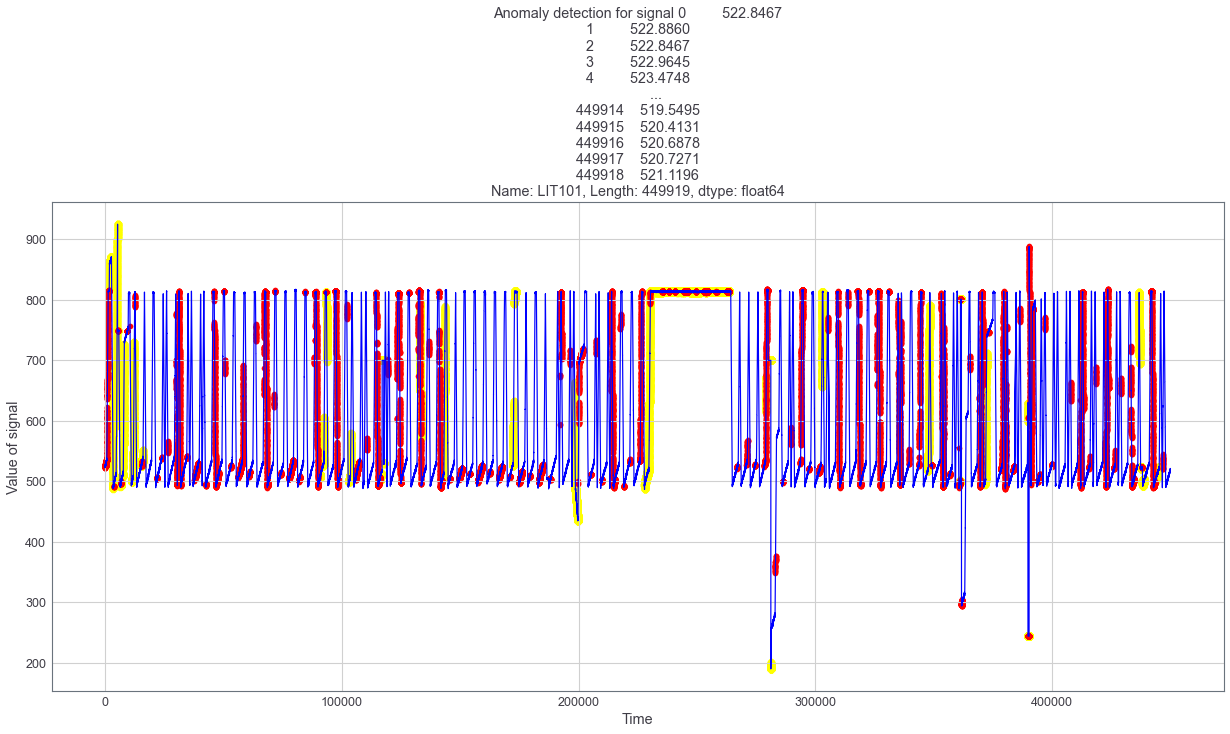

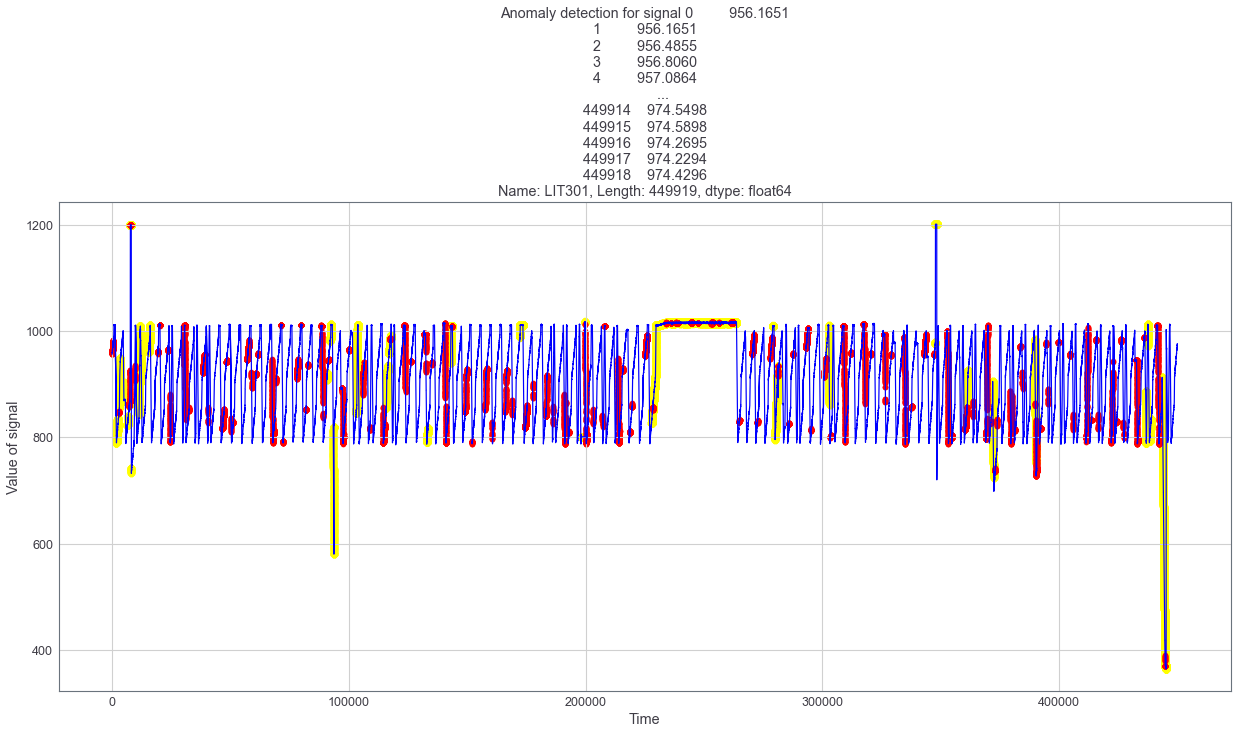

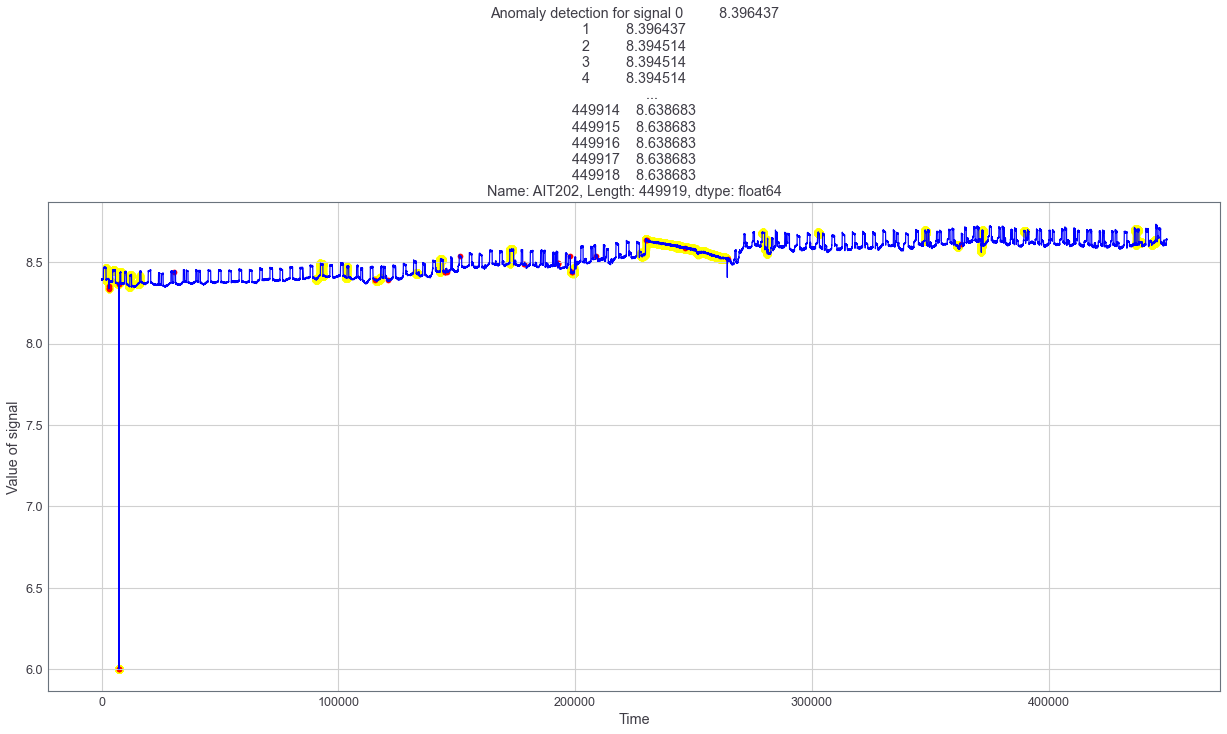

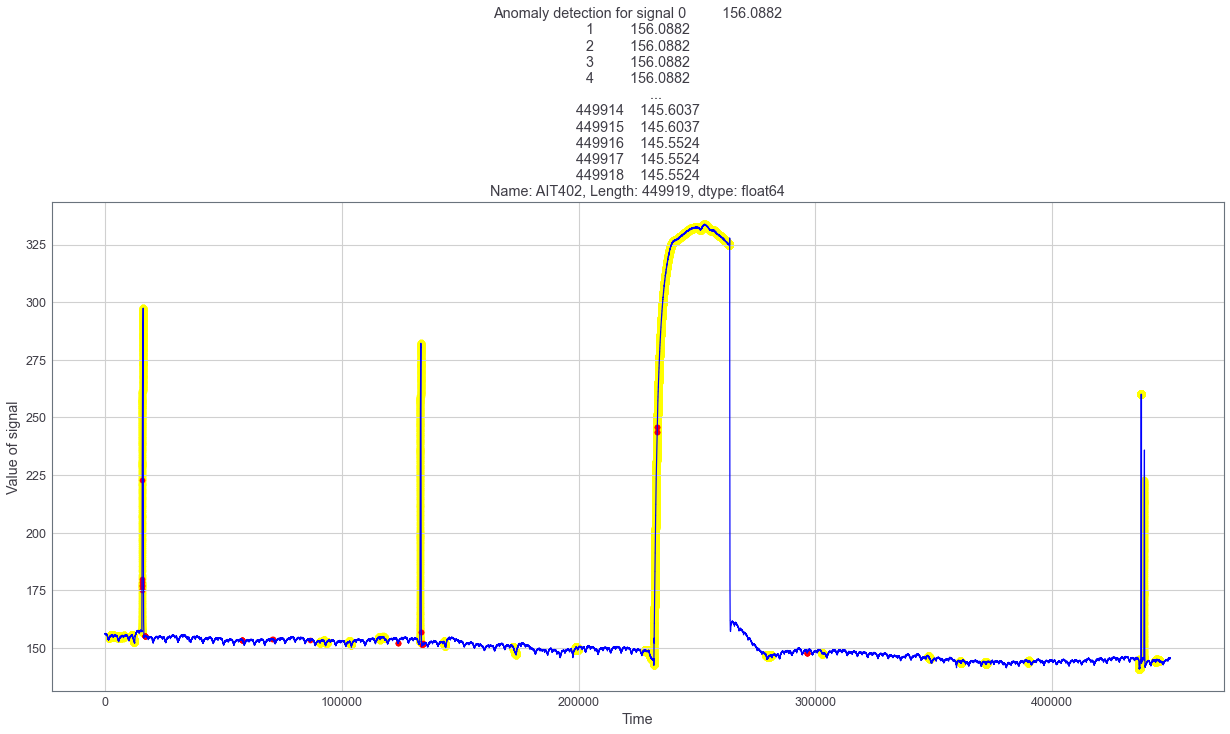

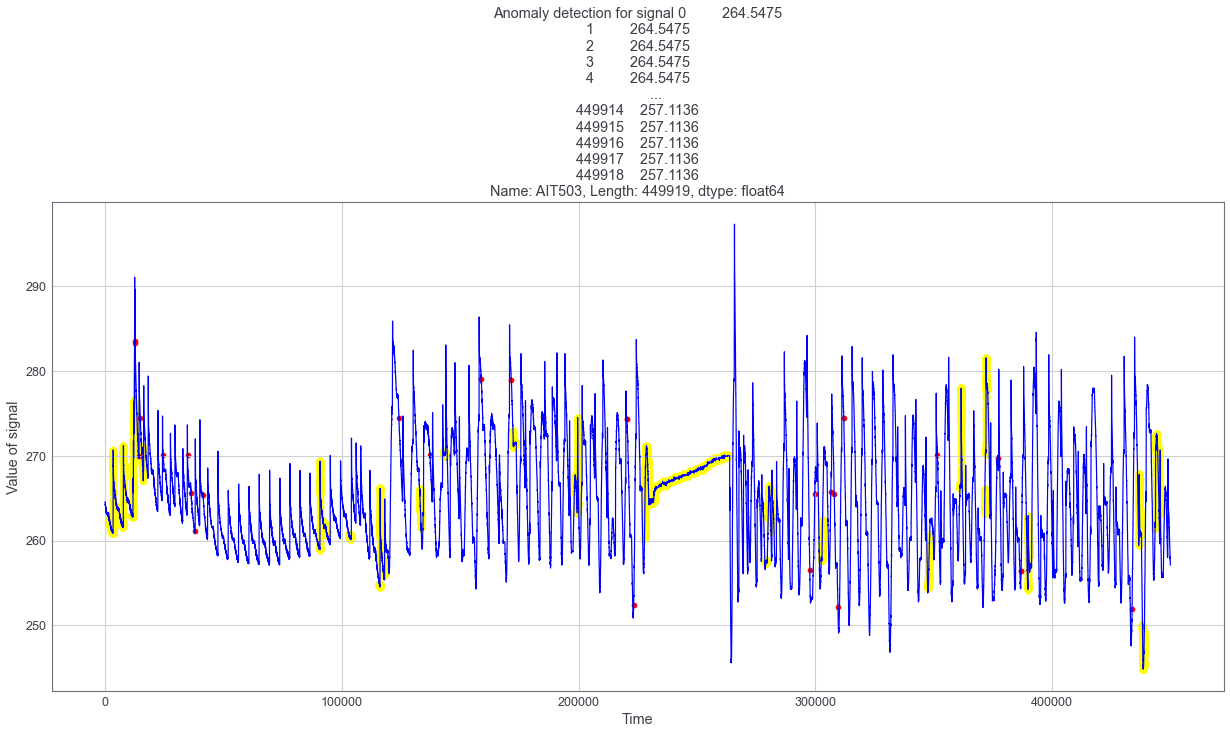

In [40]:
print("\n Figure17: plot original and discretized data for each signal in N-gram model")
show_ngram_result(ngram_signals)

### 5b. Analysis and answers to the questions. Also provide relevant plots.

#### Plot the anomalies you find. What kind of anomalies can / can you not detect?
For signal `LIT101`, the N-gram model finds the contextual anomaly from point around 230000 to 260000. And it also finds three-point anomalies around the points 360000 and 380000 in the test data set. However, it mistakenly marks many normal points as anomalies. 

For signal `LIT301`, the N-gram model finds the contextual anomaly around the point from point around 230000 to 260000 and two-point anomaly around the point 10000 and 460000 in the test data set. It fails to find another two obvious point anomaly - around the point 95000 and 350000 in the test data set.

For signal `AIT202`, the N-gram model marks several points in the contextual anomaly from point around 230000 to 260000 which reflects that it successfully judges them as collective anomalies.

For signal `AIT402`, the N-gram model distinguishes several points in the contextual anomalies from point around 230000 to 260000, however, the number of its marking is quite smaller than the real number of outliers.

For signal `AIT503`, the N-gram model marks some point anomalies while it fails to detect the obvious contextual anomaly from point 230000 to point 260000. This signal performs worst using N-gram model. 

#### Which sensors can be modeled effectively using N-grams?
As the classification we make in table, we implement the N-grams model on three kinds of signals. For the first type of signal- periodic change within a certain range, signal `LIT101` and `LIT301`, this model marks more points as an anomaly which increases the false positive value. For the second type - continuous drift, the signal `AIT202` and `AIT402`, the N-gram model marks fewer points as anomalies, which results in a lower true positive value. What's more, the signal `AIT503` performs worst.

The N-grams model is more suitable for detecting anomalies in the signal which changes periodically within a certain range.

## 6.Comparision task 1 A4

The comparison task involves comparing the four detection methods. However, the assignment was interpreted in different ways by the team partners. Therefore, we separately compare the LOF and PCA methods, and the ARIMA and NGRAM methods against each other. 

Our evaluation of each method is added at the end of each task. Here we refer these pictures above and give some explanations. 

### 6a. Use the given guidelines and provide a comparision of the above implemented methods.

LOF v.s. PCA

To compare the detection precision of LOF and PCA, we plot the confusion matrix to show their performance as we run all test data set in these two methods. Confusion matrix can evaluate the different models by breaking positives into true positives and false positives.

To perfect the comparison, we execute some selection and process these two models. For the LOF model, we choose the signal 'LIT301' to draw the confusion matrix as it performs better than any other signal or signal combination. In the PCA model, we reduce the 51-dimension features to 12 components according to the residual plot. 

From the perspective of positives, LOF seems better achieving normalized TP of 0.99 while keeping the FP to 0.01. The confusion matrix also allows us to see the False Negatives at the same time. FNs are important to keep low since it means that there is a breach in the system that we could not recognize which is more dangerous than having FPs. PCA performs better in the FN value. 

According to our results, PCA seems the better strategy as its TP value decreases by 18 percent while the FN value increases by 41 percent compared with the result of LOF. Of course, we could definitely achieve better results if we could combine these methods to detect many different kinds of anomalies. 

![Confusion Matrix of LOF](./figures/LOF_confusion.png)
<center> Confusion Matrix of LOF </center>

![Confusion Matrix of PCA](./figures/PCA_confusion.png)
<center> Confusion Matrix of PCA </center>

ARIMA v.s. N-gram

Firstly, the N-gram is better than the ARIMA model from the perspective of speed as the former one could run faster and predict for the whole test data set. However, the ARIMA model runs for half an hour for predicting 300 points. 

Secondly, the ARIMA model seems to predict the signal too well and it could only detect point anomalies or a shorter sequence of anomalies as these points deviate normal data too far. Or it needs more tuning to get better results. 

However, the ARIMA model is not useless. We select one region which contains 50 positive and 250 negative points from point 11160 to point 11460. As shown in part6 in the .ipynb file, the ARIMA model finds 23 anomalies in total 50 anomalies while all five signals of the N-gram model find nothing in this region even some signal's results mark a lot of anomalies in the total test data set. 

To sum up, the N-gram model performs better than the ARIMA model from the perspective of effectiveness and speed while the ARIMA model also performs better in some anomalous regions.

![Partially Predicted Result of ARIMA](./figures/arima_res.png)
<center> Partially Predicted Result of ARIMA </center>

## 7. Bonus Task 1 A4

### 7a. Provide implementation and analysis.